International Trade Network Analysis: Understanding Global Economic Interactions

International trade is a fundamental aspect of the global economy, influencing economic growth, development, and geopolitical relationships. Analyzing the network of trade flows between countries and the financial transactions associated with imports and exports can provide insights into global economic dynamics and interdependencies.

In [2]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import csv

In [4]:
with open(r'C:\Users\the_s\Desktop\AI Master\Social Network Analysis\countries.json', 'r') as file:
    data = json.load(file)

In [6]:
key_mapping = {
        "Economy: Real GDP (purchasing power parity)": "GDP",
        "Economy: GDP - composition, by end use - exports of goods and services": "GDP Exports",
        "Economy: GDP - composition, by end use - imports of goods and services": "GDP Imports",
        "Economy: Exports": "Exports",
        "Economy: Exports - partners": "Export Partners",
        "Economy: Exports - commodities": "Export Commodities",
        "Economy: Imports": "Imports",
        "Economy: Imports - partners": "Import Partners",
        "Economy: Imports - commodities": "Import Commodities"
    }
old_keys = list(key_mapping.keys())

data = {country: data[country] for country in data if all(key in data[country] for key in old_keys)}

Data Preprocessing

In [9]:
for country, country_data in data.items():
        filtered_renamed_data = {key_mapping.get(key, key): value for key, value in country_data.items() if key in old_keys}
        data[country] = filtered_renamed_data

for country_data in data.values():
    for key, value in country_data.items():
        tempval = value.split(' (')[0]
        country_data[key] = tempval.strip('%')
        
for country_data in data.values():
    export_partners_str = country_data['Export Partners']
    export_partners = export_partners_str.split(', ')

    export_partner_associations = {}

    for partner_str in export_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        export_partner_associations[partner] = percentage
        
    country_data['Export Partners'] = export_partner_associations

    import_partners_str = country_data['Import Partners']
    import_partners = import_partners_str.split(', ')

    import_partner_associations = {}

    for partner_str in import_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        import_partner_associations[partner] = percentage

    country_data['Import Partners'] = import_partner_associations

In [11]:
print(data['Afghanistan'])

{'GDP': '$60.802 billion', 'GDP Exports': '6.7', 'GDP Imports': '-47.6', 'Exports': '$1.476 billion', 'Export Partners': {'United Arab Emirates': '45', 'Pakistan': '24', 'India': '22', 'China': '1'}, 'Export Commodities': 'gold, figs, grapes, cotton, fruits and nuts, coal', 'Imports': '$6.983 billion', 'Import Partners': {'United Arab Emirates': '23', 'Pakistan': '17', 'India': '13', 'Uzbekistan': '7', 'China': '9'}, 'Import Commodities': 'wheat flours, broadcasting equipment, refined petroleum, rolled tobacco, aircraft parts, synthetic fabrics'}


In [13]:
country_mapping = {
    'UK': 'United Kingdom',
    'US': 'United States',
    'UAE': 'United Arab Emirates',
    'Gambia, The': 'Gambia',
    'Turkey (Turkiye)': 'Turkey',
    'Congo, Democratic Republic of the': 'Congo',
    'Democratic Republic of the Congo': 'Congo',
    'Congo, Republic of the': 'Congo',
    'Republic of the Congo': 'Congo',
    'Korea, South': 'South Korea',
    'Korea, North': 'North Korea',
    'Cost Rica': 'Costa Rica',
    'NZ': 'New Zealand',
    'Micronesia, Federated States of': 'Micronesia'
}

In [15]:
### Exports df
export_data = []
for country, exports in data.items():
    export_partners = exports.get('Export Partners', {})
    for partner, weight in export_partners.items():
        if partner in country_mapping:
            partner = country_mapping[partner]
        
        if country in country_mapping:
            country = country_mapping[country]
        

        
        export_data.append({'source': country, 'target': partner, 'weight': float(weight)})
        

exports_df = pd.DataFrame(export_data)
exports_df

,source,target,weight
0,Afghanistan,United Arab Emirates,45.0
1,Afghanistan,Pakistan,24.0
2,Afghanistan,India,22.0
3,Afghanistan,China,1.0
4,Albania,Italy,45.0
...,...,...,...
971,Zambia,Congo,9.0
972,Zambia,Singapore,8.0
973,Zimbabwe,United Arab Emirates,40.0
974,Zimbabwe,South Africa,23.0


In [17]:
### Imports df
import_data = []
for country, imports in data.items():
    import_partners = imports.get('Import Partners', {})
    for partner, weight in import_partners.items():
        if partner in country_mapping:
            partner = country_mapping[partner]
        
        if country in country_mapping:
            country = country_mapping[country]

        
        import_data.append({'source': country, 'target': partner, 'weight': float(weight)})

imports_df = pd.DataFrame(import_data)
imports_df

,source,target,weight
0,Afghanistan,United Arab Emirates,23.0
1,Afghanistan,Pakistan,17.0
2,Afghanistan,India,13.0
3,Afghanistan,Uzbekistan,7.0
4,Afghanistan,China,9.0
...,...,...,...
1000,Zambia,Congo,6.0
1001,Zambia,India,5.0
1002,Zimbabwe,South Africa,41.0
1003,Zimbabwe,Singapore,23.0


Graph

In [20]:
# Create directed graphs for imports and exports
G_imports = nx.DiGraph()
G_exports = nx.DiGraph()

# Add edges from exports
for _, row in exports_df.iterrows():
    G_exports.add_edge(row['source'], row['target'], weight=row['weight'])

# Add edges from imports
for _, row in imports_df.iterrows():
    G_imports.add_edge(row['source'], row['target'], weight=row['weight'])

# Check number of nodes
num_nodes_export = G_exports.number_of_nodes()
num_nodes_import = G_imports.number_of_nodes()
print(f"Number of nodes in export graph: {num_nodes_export}")
print(f"Number of nodes in import graph: {num_nodes_import}")

Number of nodes in export graph: 209
Number of nodes in import graph: 207


In [22]:
nodes_export = set(G_exports.nodes())
nodes_import = set(G_imports.nodes())

common_nodes = nodes_export.intersection(nodes_import)

print(f"Number of common nodes: {len(common_nodes)}")

Number of common nodes: 207


In [24]:
# Create subgraphs with only the common nodes
G_export = G_exports.subgraph(common_nodes).copy()
G_import = G_imports.subgraph(common_nodes).copy()

eliminated_from_exports = nodes_export - common_nodes
eliminated_from_imports = nodes_import - common_nodes

countries = G_import.nodes()
print(f"Nodes eliminated from export graph: {eliminated_from_exports}")
print(f"Nodes eliminated from import graph: {eliminated_from_imports}")

Nodes eliminated from export graph: {'Guadeloupe', 'Martinique'}
Nodes eliminated from import graph: set()


Measures

Degree Centrailty

Nodes with high degree centrality have a large number of connections and are considered influential or important within the network. Nodes with high degree centrality can be critical for maintaining the integrity of the network. Their removal might significantly disrupt the network's connectivity.

-----Exports Network-----


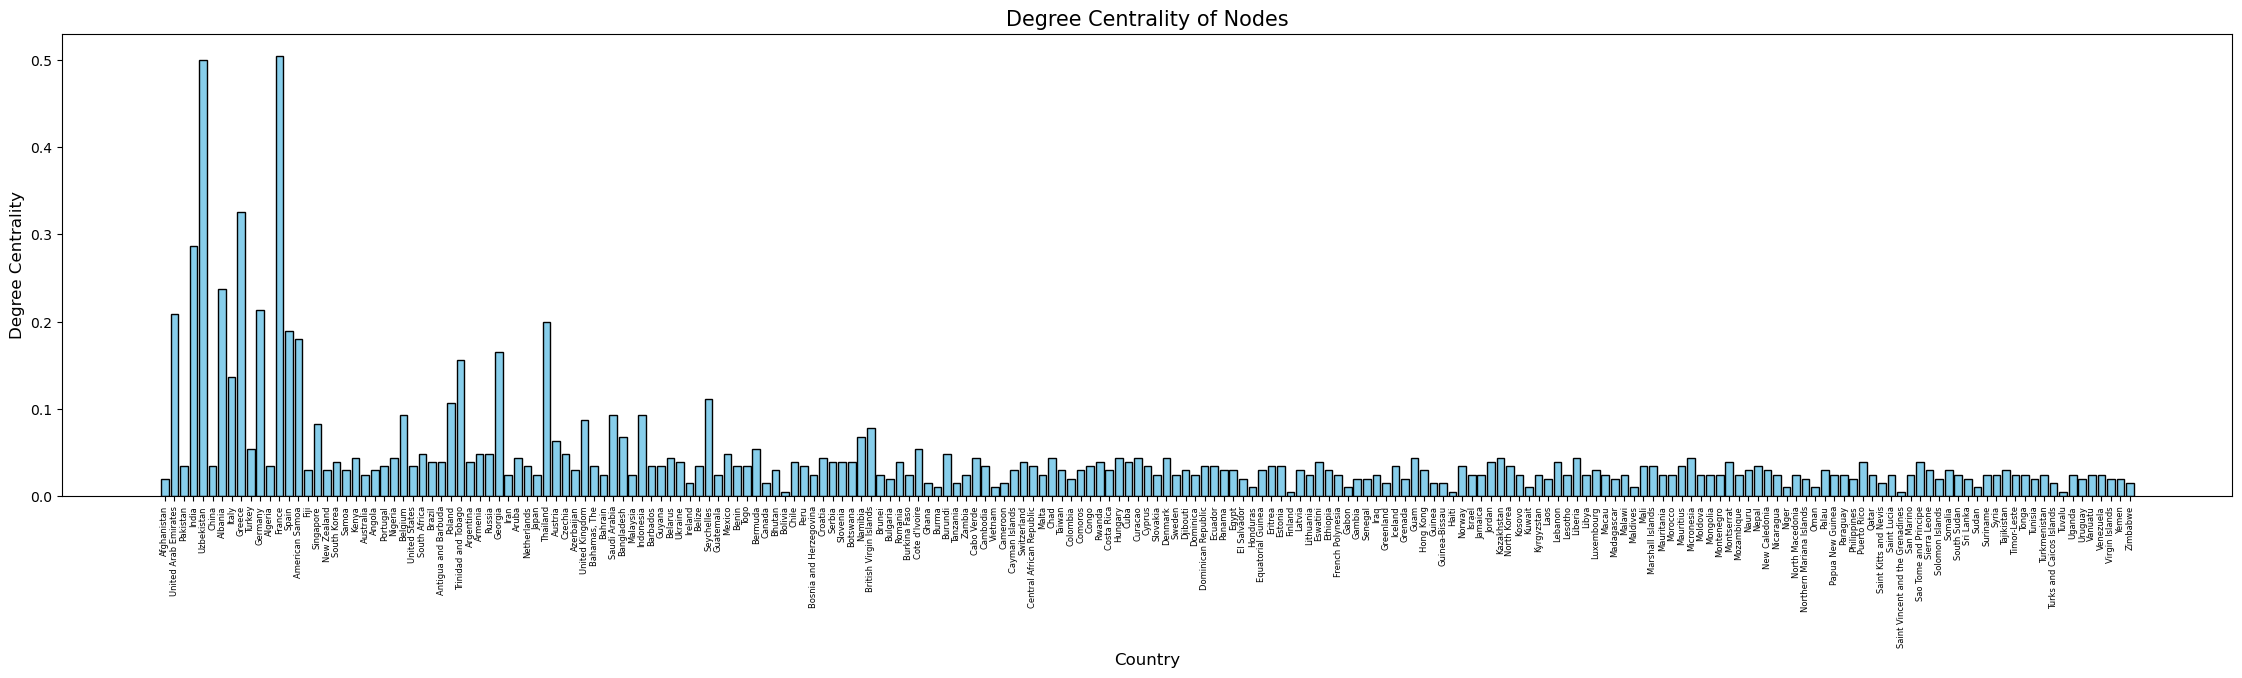

Nodes (Countries) with High Degree Centrality (> 0.3):
China: 0.5000
Germany: 0.3252
United States: 0.5049

-----Imports Network-----


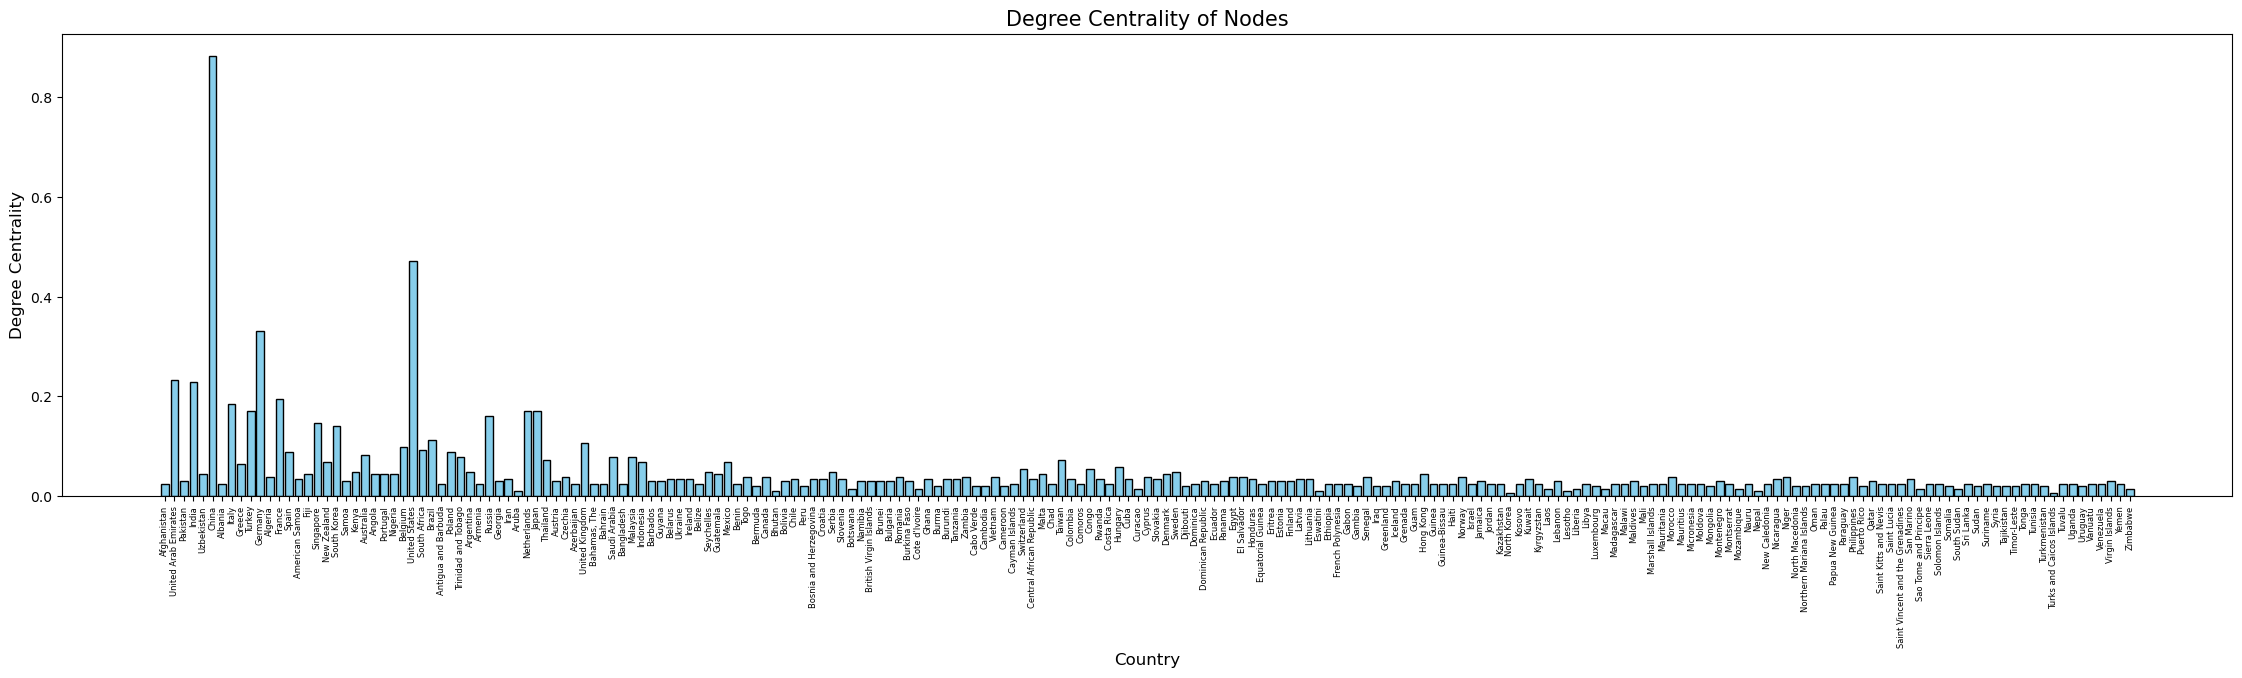

Nodes (Countries) with High Degree Centrality (> 0.3):
China: 0.8835
Germany: 0.3301
United States: 0.4709


In [29]:
degree_centrality_export = nx.degree_centrality(G_export)
degree_centrality_import = nx.degree_centrality(G_import)

degree_centrality_values_export = list(degree_centrality_export.values())
degree_centrality_values_import = list(degree_centrality_import.values())

# Plot histogram
def centrality(countries, cent, centrality_values, type, threshold):
    plt.figure(figsize=(28, 6))
    plt.bar(countries, centrality_values, color='skyblue', edgecolor='black')
    plt.xticks(rotation=90, fontsize=6)
    plt.title(type+' of Nodes', fontsize=15)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel(type, fontsize=12)
    plt.show()

    high_centrality_nodes = {node: centrality for node, centrality in cent.items() if centrality > threshold}
    print('Nodes (Countries) with High '+type+' (> '+str(threshold)+'):')
    for node, centrality in high_centrality_nodes.items():
        print(f"{node}: {centrality:.4f}")
    return high_centrality_nodes
    
print("-----Exports Network-----")
high_degree_nodes_export = centrality(countries, degree_centrality_export, degree_centrality_values_export, type='Degree Centrality',threshold=0.3)
print("\n-----Imports Network-----")
high_degree_nodes_import = centrality(countries, degree_centrality_import, degree_centrality_values_import, type='Degree Centrality',threshold=0.3)

Degree Centrailty Distribution

We calculate the degree centrality distribution and fit a power-law model to the log-transformed degree centrality values. This approach can reveal if the network follows a power-law distribution, which is common in many real-world networks.

-----Exports Network-----


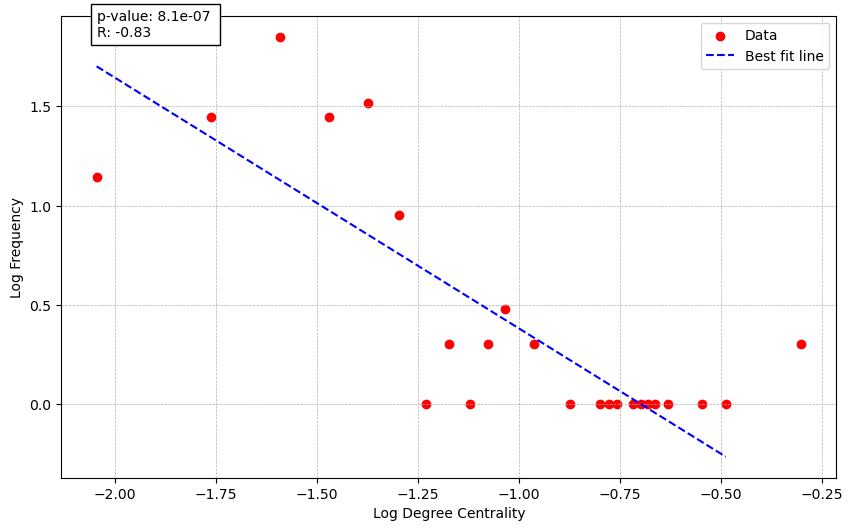

The slope of the line is: -1.2630009291737454

-----Imports Network-----


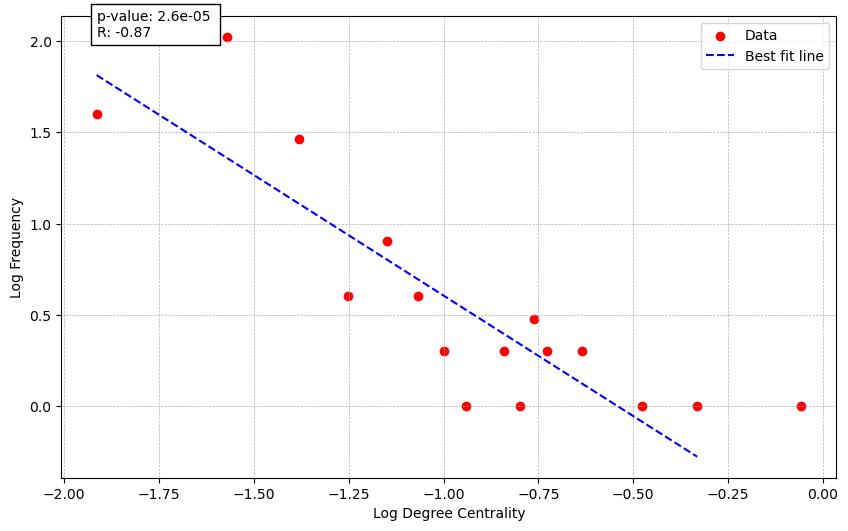

The slope of the line is: -1.322512036501067


In [32]:
def plot_centrality_power_law(centrality_values, G, bins, type):
    
    # Calculate histogram
    freq, bins = np.histogram(centrality_values, bins=bins)
    
    # Calculate bin centers
    x = (bins[:-1] + bins[1:]) / 2  # x = center value of each bin
    y = freq  # y = occurrence
    
    # Filter out zero values
    non_zero_indices = np.where(y > 0)
    x_display = x[non_zero_indices]
    y_display = y[non_zero_indices]
    
    # Exclude the last value for the fit (if it's an outlier)
    fit_points = np.where(x_display < np.max(x_display))
    x_fit = x_display[fit_points]
    y_fit = y_display[fit_points]
    
    # Take the logarithm of x and y
    log_x_display = np.log10(x_display)
    log_y_display = np.log10(y_display)
    log_x_fit = np.log10(x_fit)
    log_y_fit = np.log10(y_fit)
    
    # Fit a straight line to the data
    coeffs = np.polyfit(log_x_fit, log_y_fit, 1)
    
    # Generate y-values for the fitted line
    fitted_y = coeffs[0] * log_x_fit + coeffs[1]
    
    # Perform linear regression and get p-value
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_fit, log_y_fit)
    
    # Plot the data and the fit
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x_display, log_y_display, color='r', label='Data')
    plt.plot(log_x_fit, fitted_y, 'b--', label='Best fit line')  # Plot fitted line
    plt.legend()
    plt.xlabel('Log '+type+' Centrality')
    plt.ylabel('Log Frequency')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.text(min(log_x_display), max(log_y_display), f'p-value: {p_value:.1e} \nR: {r_value:.2f}', bbox=dict(facecolor='white')) # Add p-value to the plot
    
    plt.show()
    
    print(f"The slope of the line is: {slope}")
    return slope
print("-----Exports Network-----")
slope = plot_centrality_power_law(degree_centrality_values_export, G_export, bins=60, type='Degree')
print("\n-----Imports Network-----")
slope = plot_centrality_power_law(degree_centrality_values_import, G_import, bins=60, type='Degree')

Cumulative Distribution for Degree Centrality

-----Exports Network-----


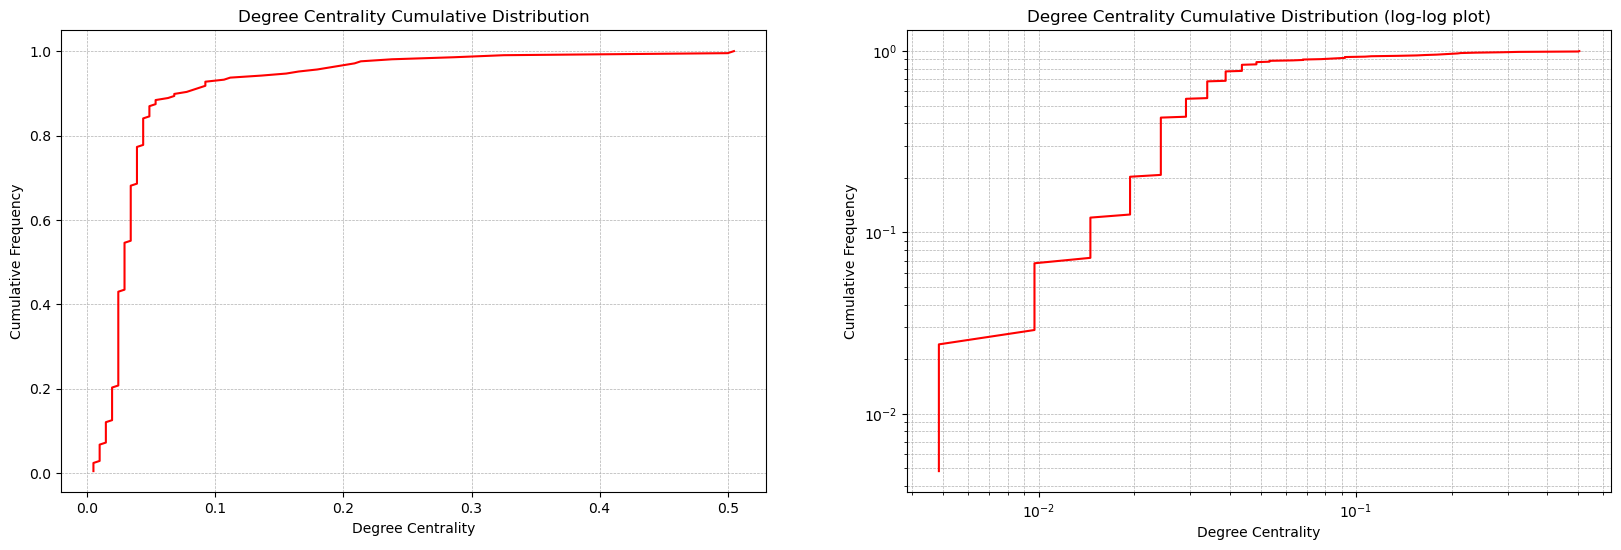


-----Imports Network-----


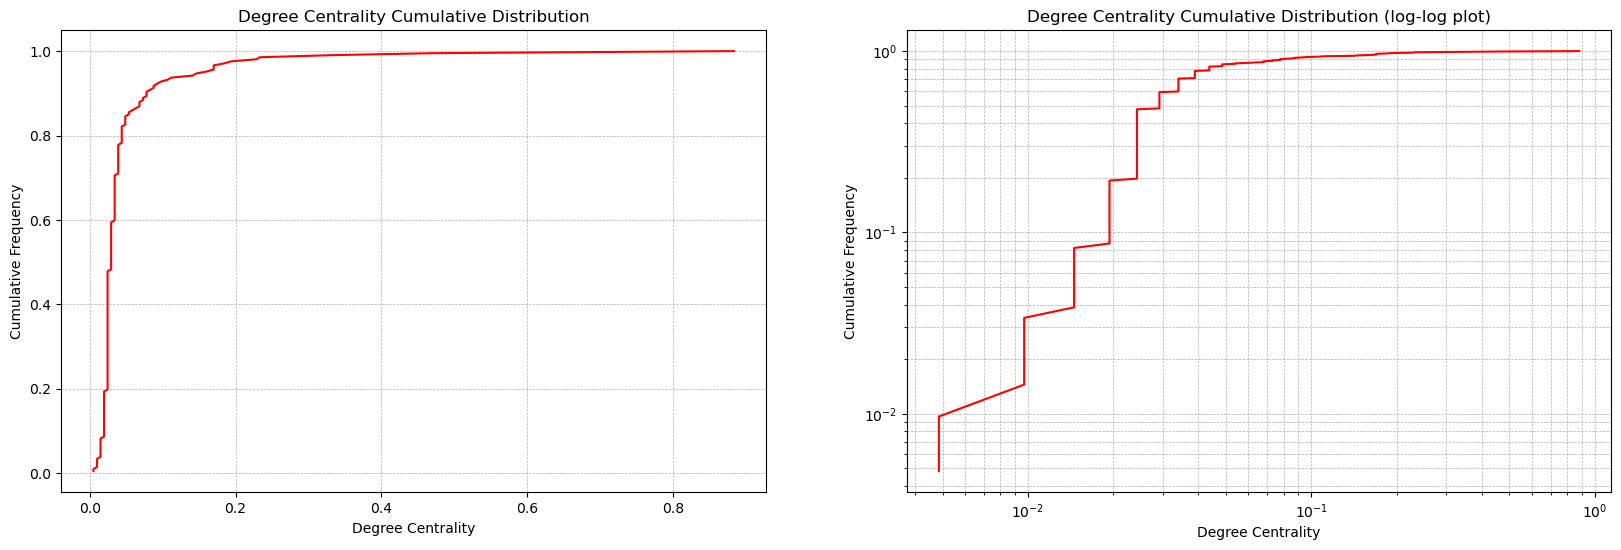

In [34]:
def cumulative_distribution(centrality_values,type):
    # Sort the degree centrality values
    sorted_centrality_values = np.sort(centrality_values)
    
    # Cumulative distribution
    cdf = np.arange(1, len(sorted_centrality_values) + 1) / len(sorted_centrality_values)
    
    # CDF Plot
    plt.figure(figsize=(20, 6))
    
    # Linear scale plot
    plt.subplot(1, 2, 1)
    plt.plot(sorted_centrality_values, cdf, color='r')
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Log-log scale plot
    plt.subplot(1, 2, 2)
    plt.plot(sorted_centrality_values, cdf, color='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution (log-log plot)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.show()
    
print("-----Exports Network-----")
cumulative_distribution(degree_centrality_values_export,type='Degree')
print("\n-----Imports Network-----")
cumulative_distribution(degree_centrality_values_import,type='Degree')

Eigenvector centrality

Eigenvector centrality is a measure of the influence of a node in a network. Unlike degree centrality, which only considers the number of direct connections a node has, eigenvector centrality also considers the importance of the nodes to which it is connected. A node with high eigenvector centrality is connected to many nodes that themselves have high centrality.

-----Exports Network-----


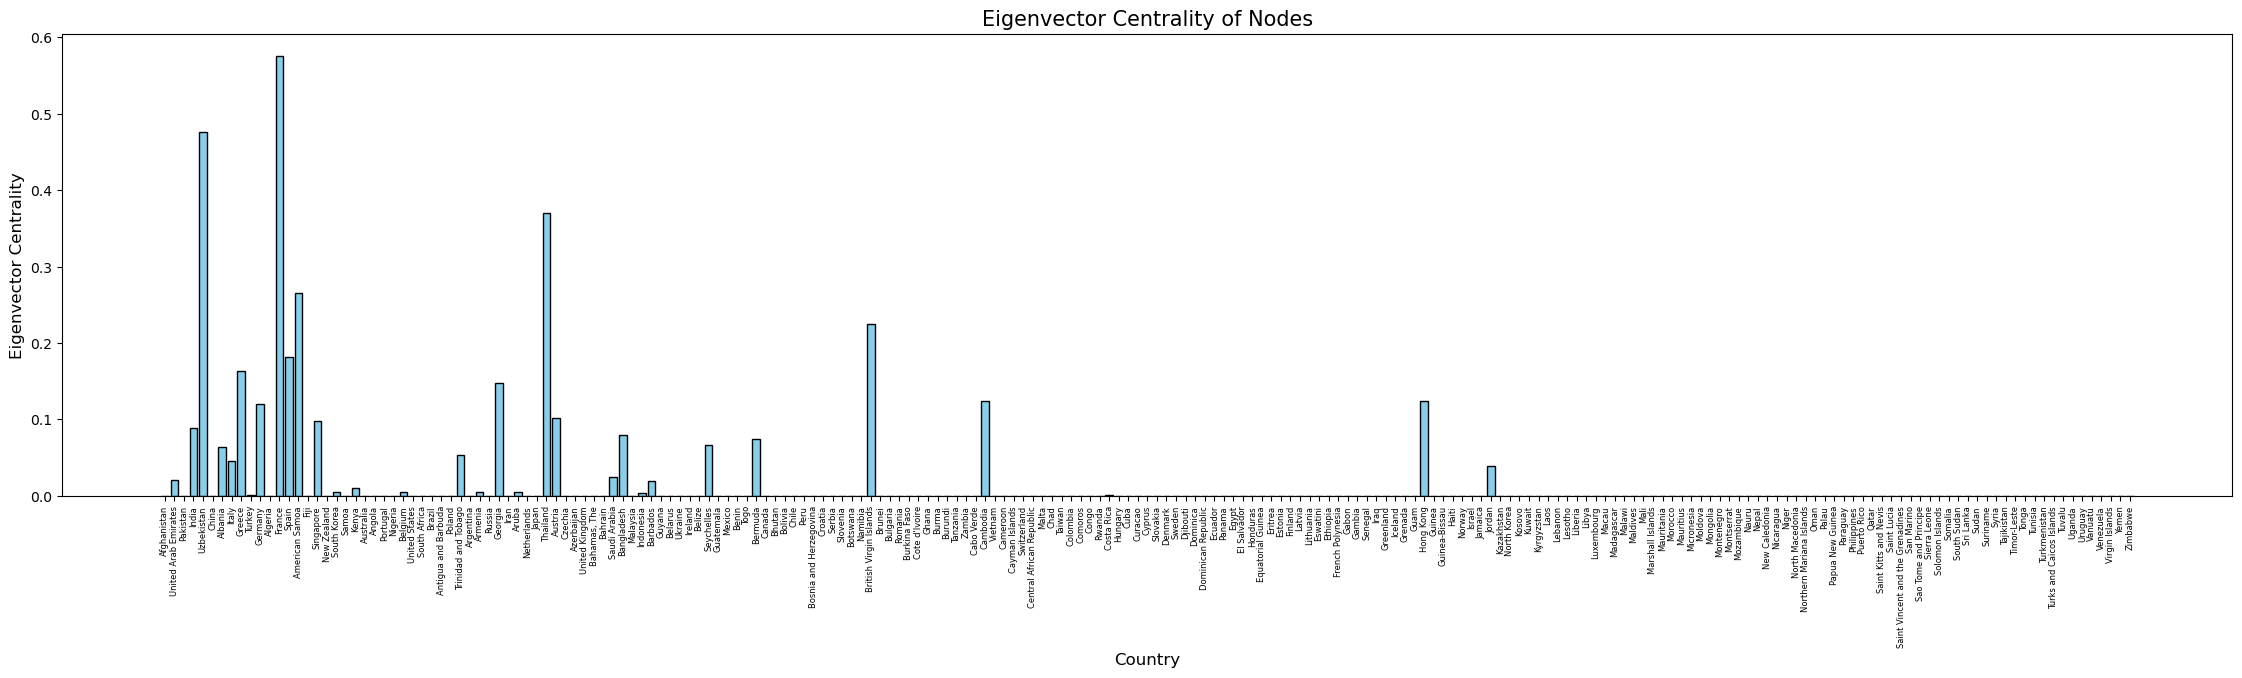

Nodes (Countries) with High Eigenvector Centrality (> 0.3):
China: 0.4764
United States: 0.5758
Japan: 0.3699

-----Imports Network-----


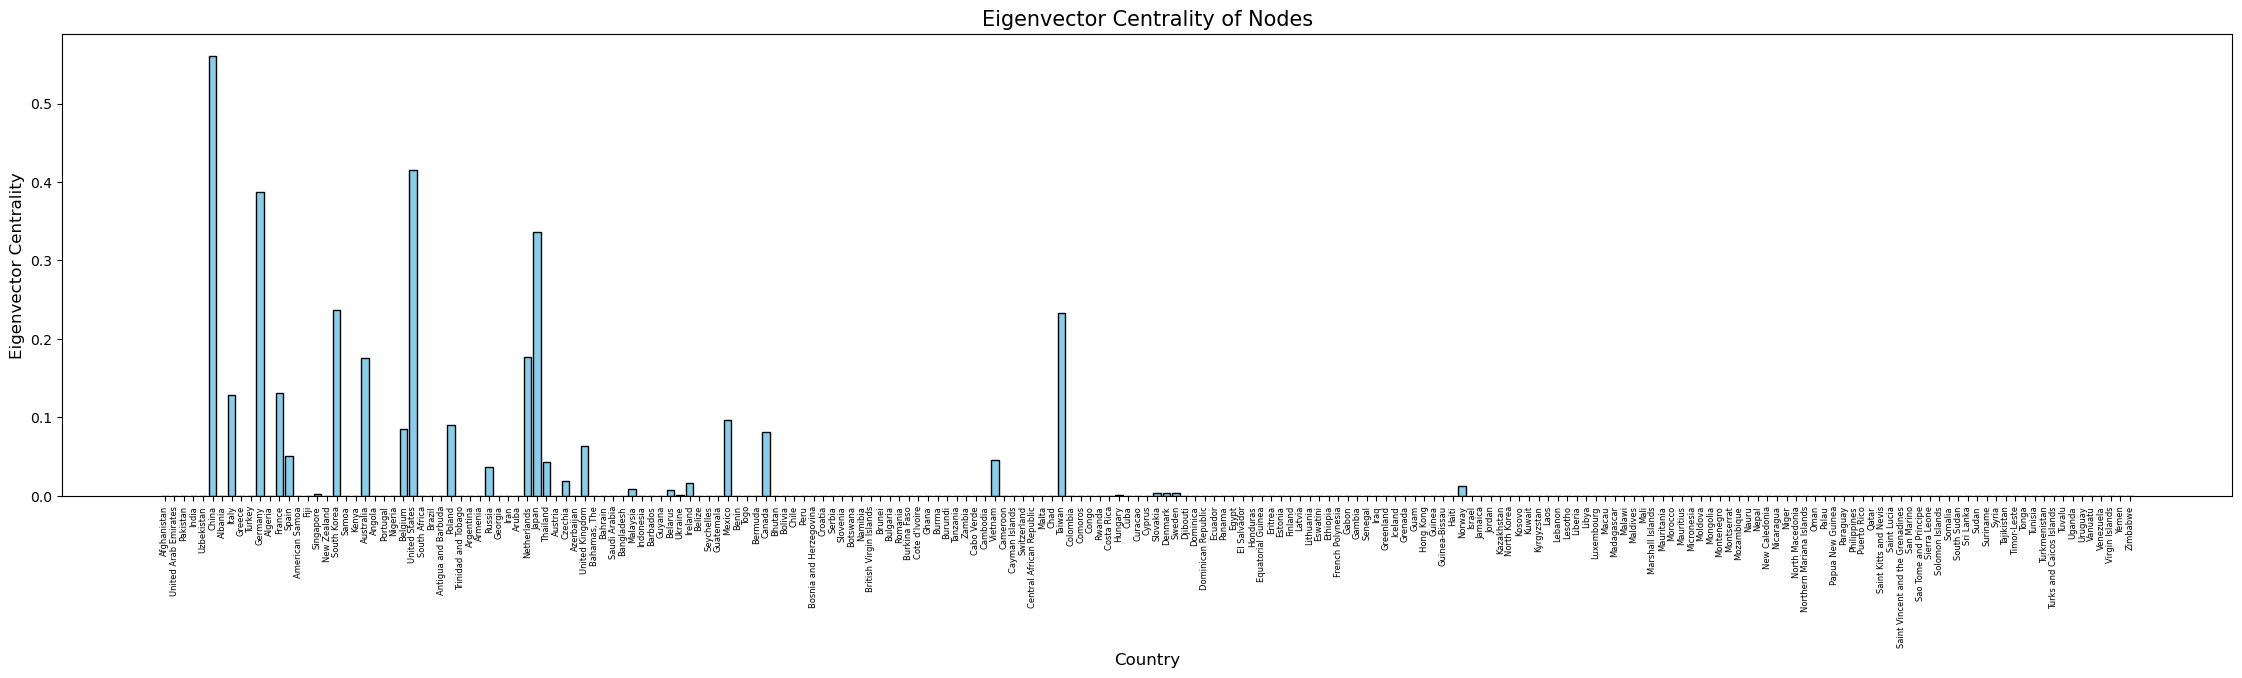

Nodes (Countries) with High Eigenvector Centrality (> 0.3):
China: 0.5607
Germany: 0.3870
United States: 0.4158
Japan: 0.3361


In [40]:
eigenvector_centrality_export = nx.eigenvector_centrality(G_export)
eigenvector_centrality_import = nx.eigenvector_centrality(G_import)

eigenvector_centrality_values_export = list(eigenvector_centrality_export.values())
eigenvector_centrality_values_import = list(eigenvector_centrality_import.values())

print("-----Exports Network-----")
high_eigenvector_nodes_export = centrality(countries, eigenvector_centrality_export, eigenvector_centrality_values_export, type='Eigenvector Centrality',threshold=0.3)
print("\n-----Imports Network-----")
high_eigenvector_nodes_import = centrality(countries, eigenvector_centrality_import, eigenvector_centrality_values_import, type='Eigenvector Centrality',threshold=0.3)

Eigenvector centrality distribution

-----Exports Network-----


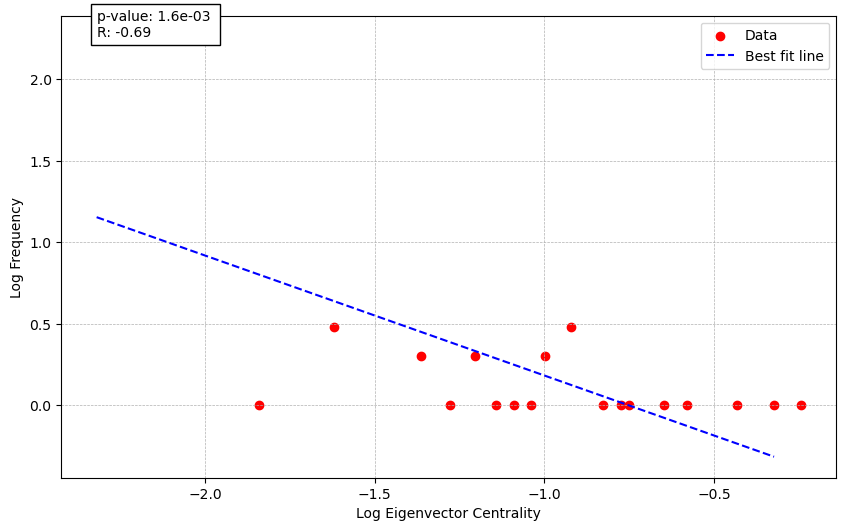

The slope of the line is: -0.7364451312092158

-----Imports Network-----


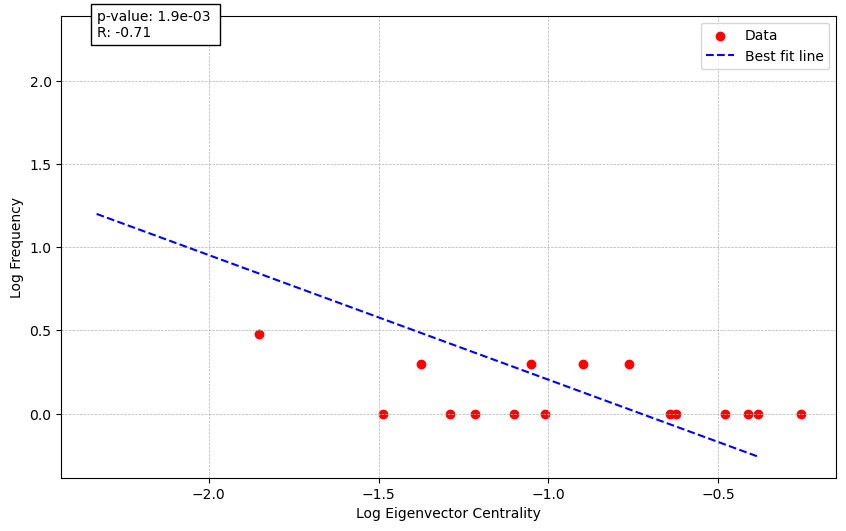

The slope of the line is: -0.749266711996696


In [43]:
print("-----Exports Network-----")
slope_e_export = plot_centrality_power_law(eigenvector_centrality_values_export, G_export, bins=60, type='Eigenvector')
print("\n-----Imports Network-----")
slope_e_import = plot_centrality_power_law(eigenvector_centrality_values_import, G_import, bins=60, type='Eigenvector')

Cumulative Distribution for Eigenvector Centrality

-----Exports Network-----


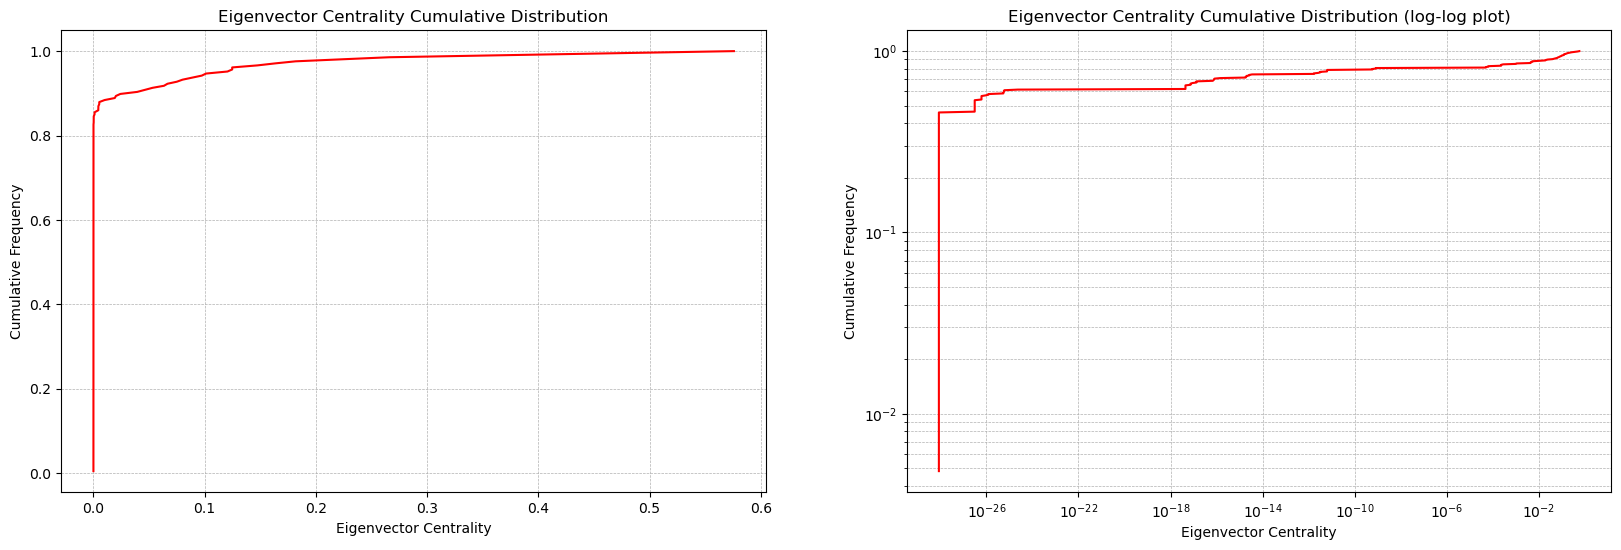


-----Imports Network-----


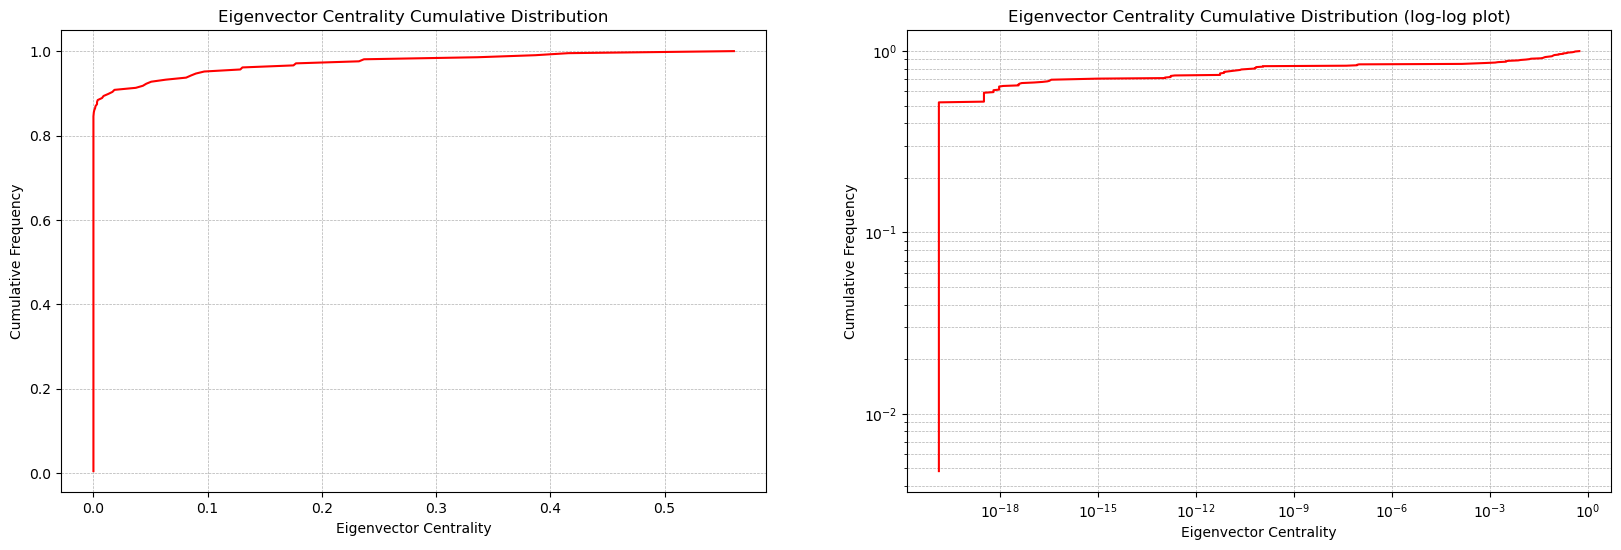

In [46]:
print("-----Exports Network-----")
cumulative_distribution(eigenvector_centrality_values_export,type='Eigenvector')
print("\n-----Imports Network-----")
cumulative_distribution(eigenvector_centrality_values_import,type='Eigenvector')

Betweenness centrality

Betweenness centrality is a measure of a node's importance based on its position within the network. Specifically, it quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. Nodes with high betweenness centrality have significant influence within the network because they control the flow of information between other nodes.

-----Exports Network-----


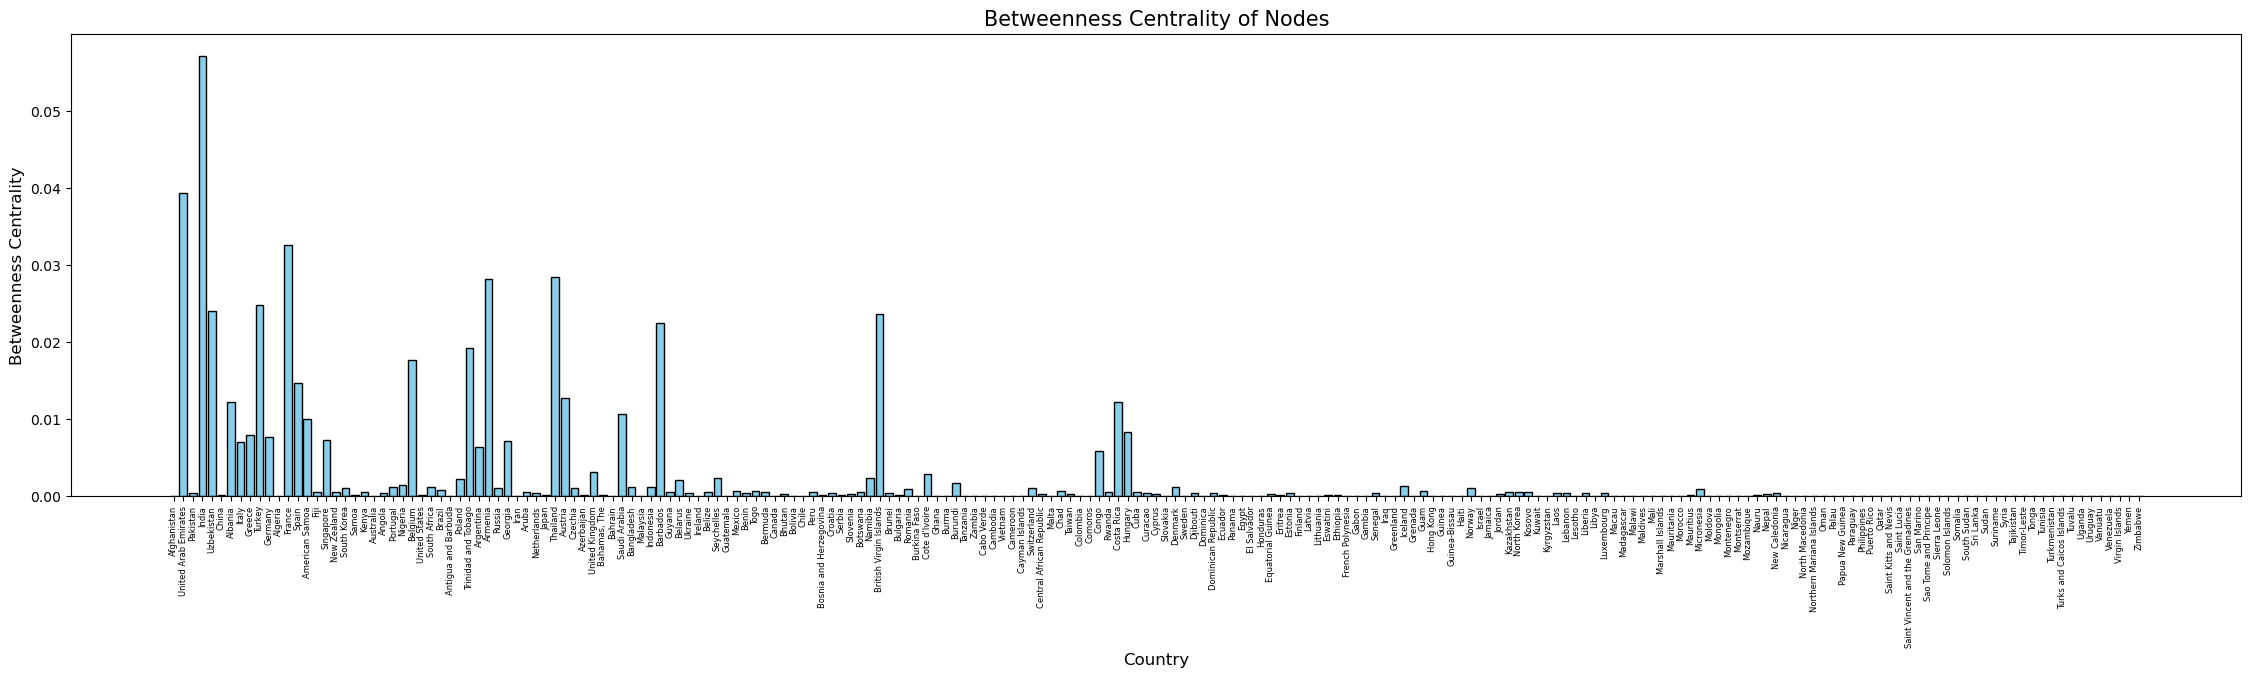

Nodes (Countries) with High Betweenness Centrality (> 0.015):
United Arab Emirates: 0.0393
India: 0.0571
China: 0.0240
Greece: 0.0248
United States: 0.0325
Poland: 0.0176
Switzerland: 0.0192
Iraq: 0.0282
Japan: 0.0284
Bangladesh: 0.0224
Hong Kong: 0.0236

-----Imports Network-----


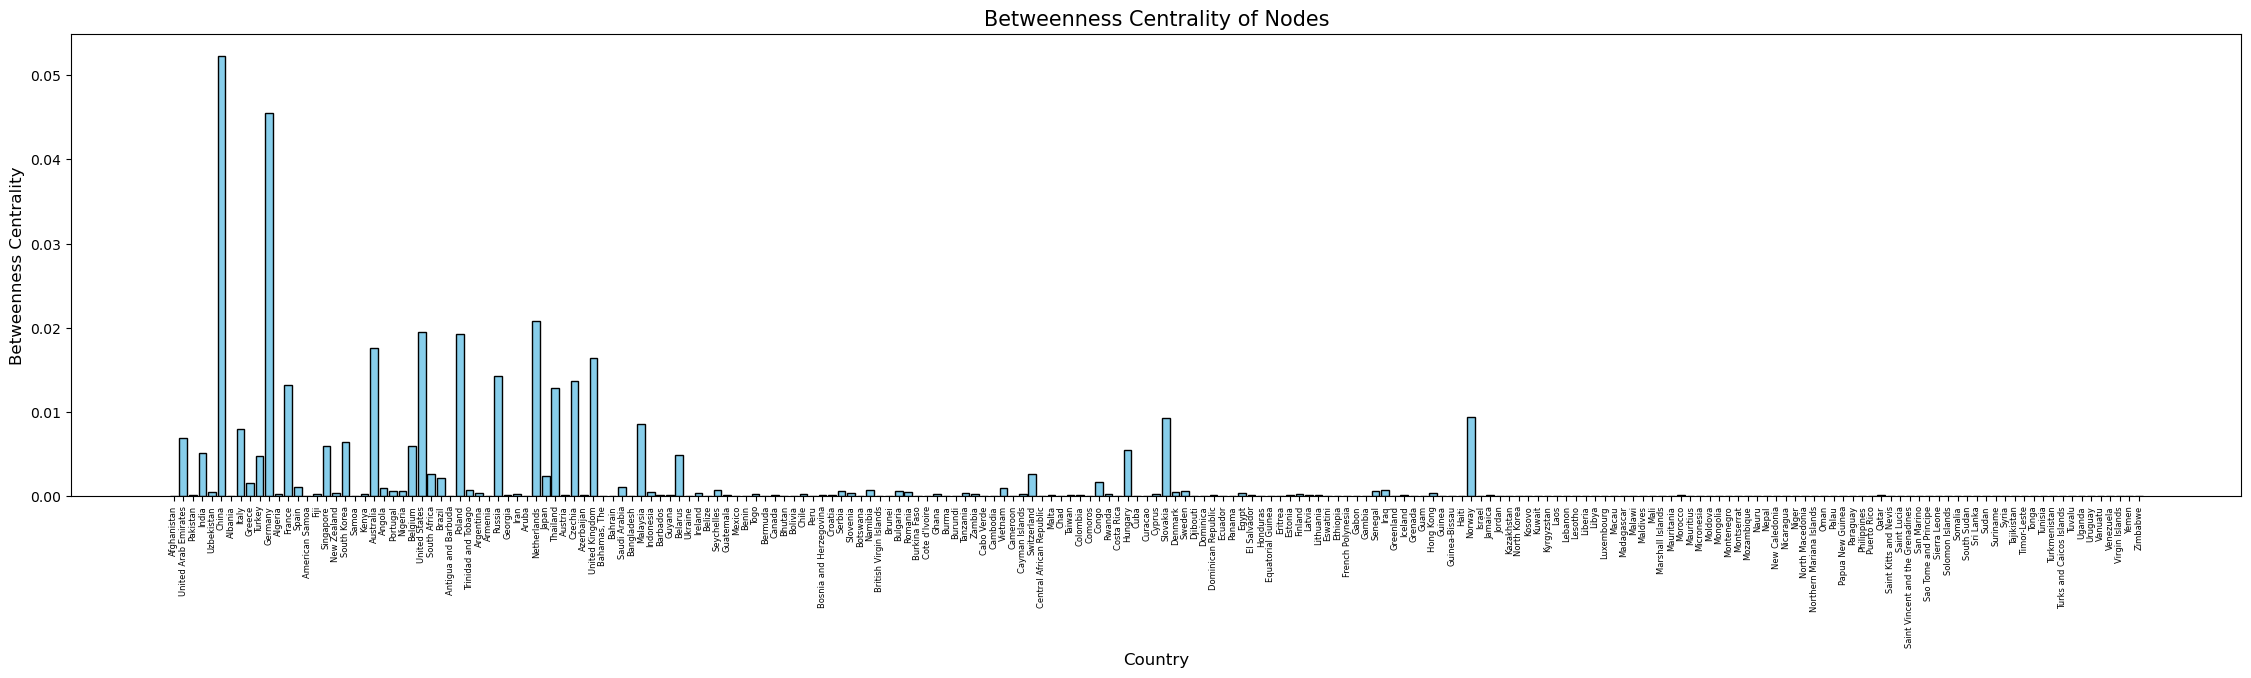

Nodes (Countries) with High Betweenness Centrality (> 0.015):
China: 0.0523
Germany: 0.0455
Australia: 0.0175
United States: 0.0195
Poland: 0.0192
Netherlands: 0.0208
United Kingdom: 0.0164


In [49]:
betweenness_centrality_export = nx.betweenness_centrality(G_export)
betweenness_centrality_import = nx.betweenness_centrality(G_import)

betweenness_centrality_values_export = list(betweenness_centrality_export.values())
betweenness_centrality_values_import = list(betweenness_centrality_import.values())

print("-----Exports Network-----")
high_betweenness_nodes_export = centrality(countries, betweenness_centrality_export, betweenness_centrality_values_export, type='Betweenness Centrality',threshold=0.015)
print("\n-----Imports Network-----")
high_betweenness_nodes_export = centrality(countries, betweenness_centrality_import, betweenness_centrality_values_import, type='Betweenness Centrality',threshold=0.015)

Betweenness Centrality distribution

-----Exports Network-----


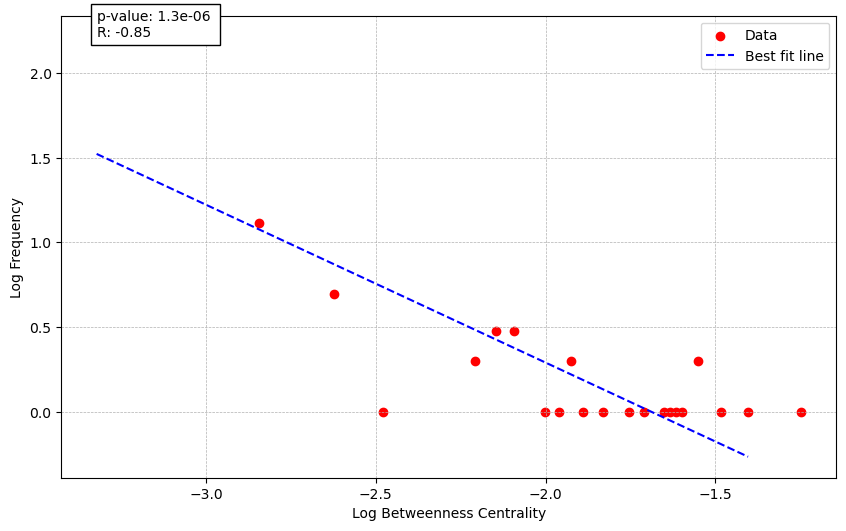

The slope of the line is: -0.9296039841746151
\Imports Graph


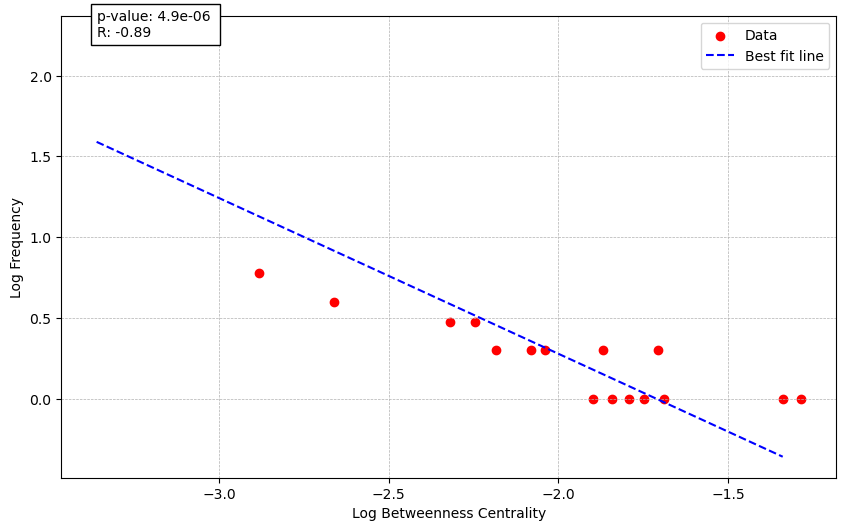

The slope of the line is: -0.9631881161012804


In [52]:
print("-----Exports Network-----")
slope_b_export = plot_centrality_power_law(betweenness_centrality_values_export, G_export, bins=60, type='Betweenness')
print("\Imports Graph")
slope_b_import = plot_centrality_power_law(betweenness_centrality_values_import, G_import, bins=60, type='Betweenness')

Cumulative Distribution for Betweenness Centrality

-----Exports Network-----


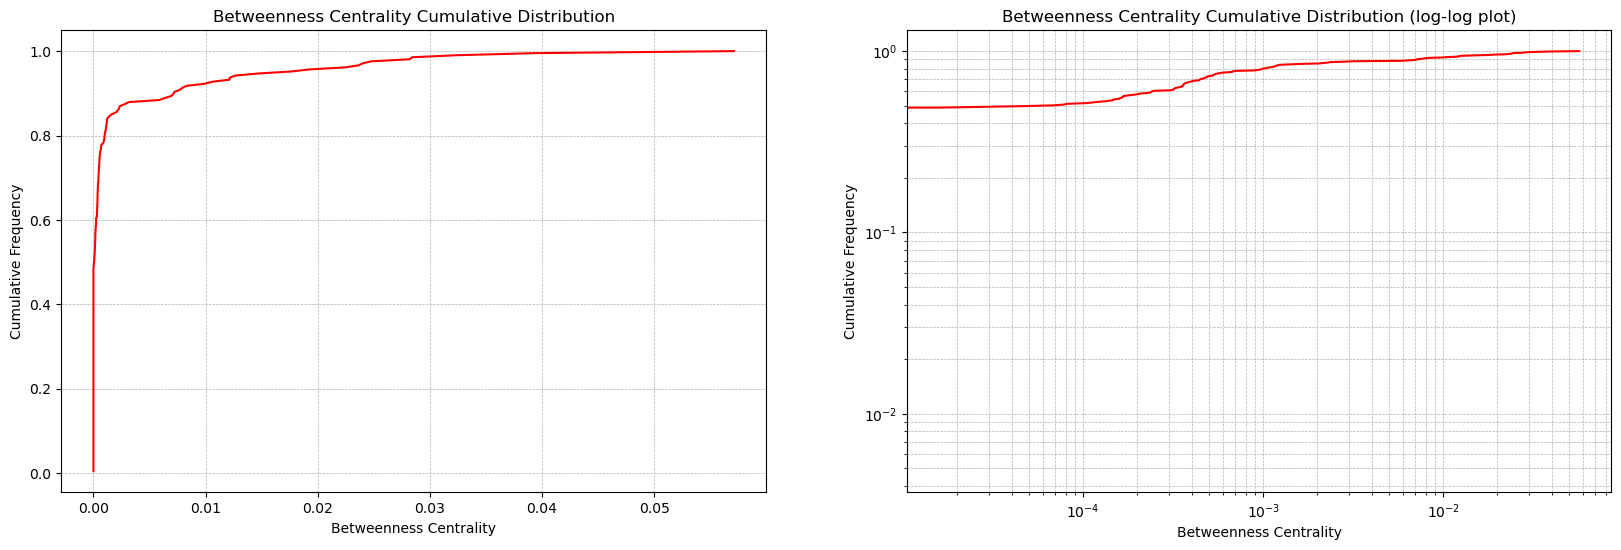


-----Imports Network-----


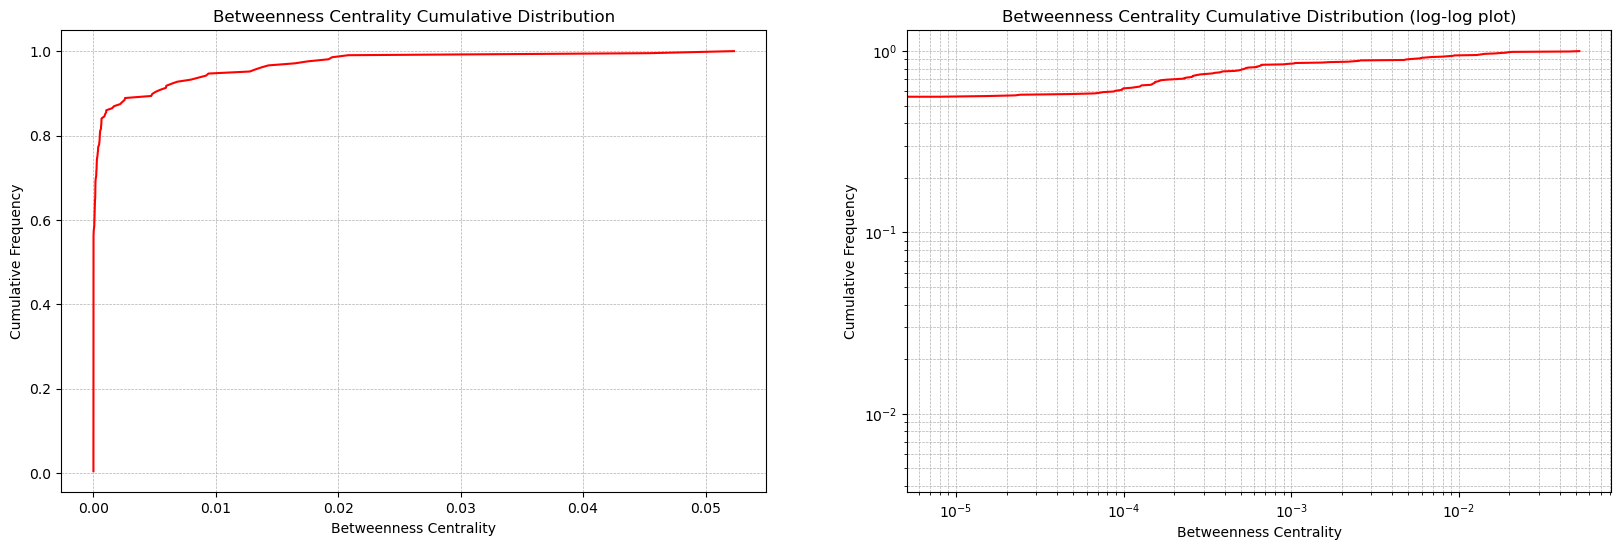

In [54]:
print("-----Exports Network-----")
cumulative_distribution(betweenness_centrality_values_export,type='Betweenness')
print("\n-----Imports Network-----")
cumulative_distribution(betweenness_centrality_values_import,type='Betweenness')

Closeness centrality

Closeness centrality is a measure of how quickly a node can reach all other nodes in a network. It is calculated as the reciprocal of the average shortest path distance from a node to all other nodes. Nodes with high closeness centrality can quickly communicate with all other nodes, making them effective for disseminating information or resources.

-----Exports Network-----


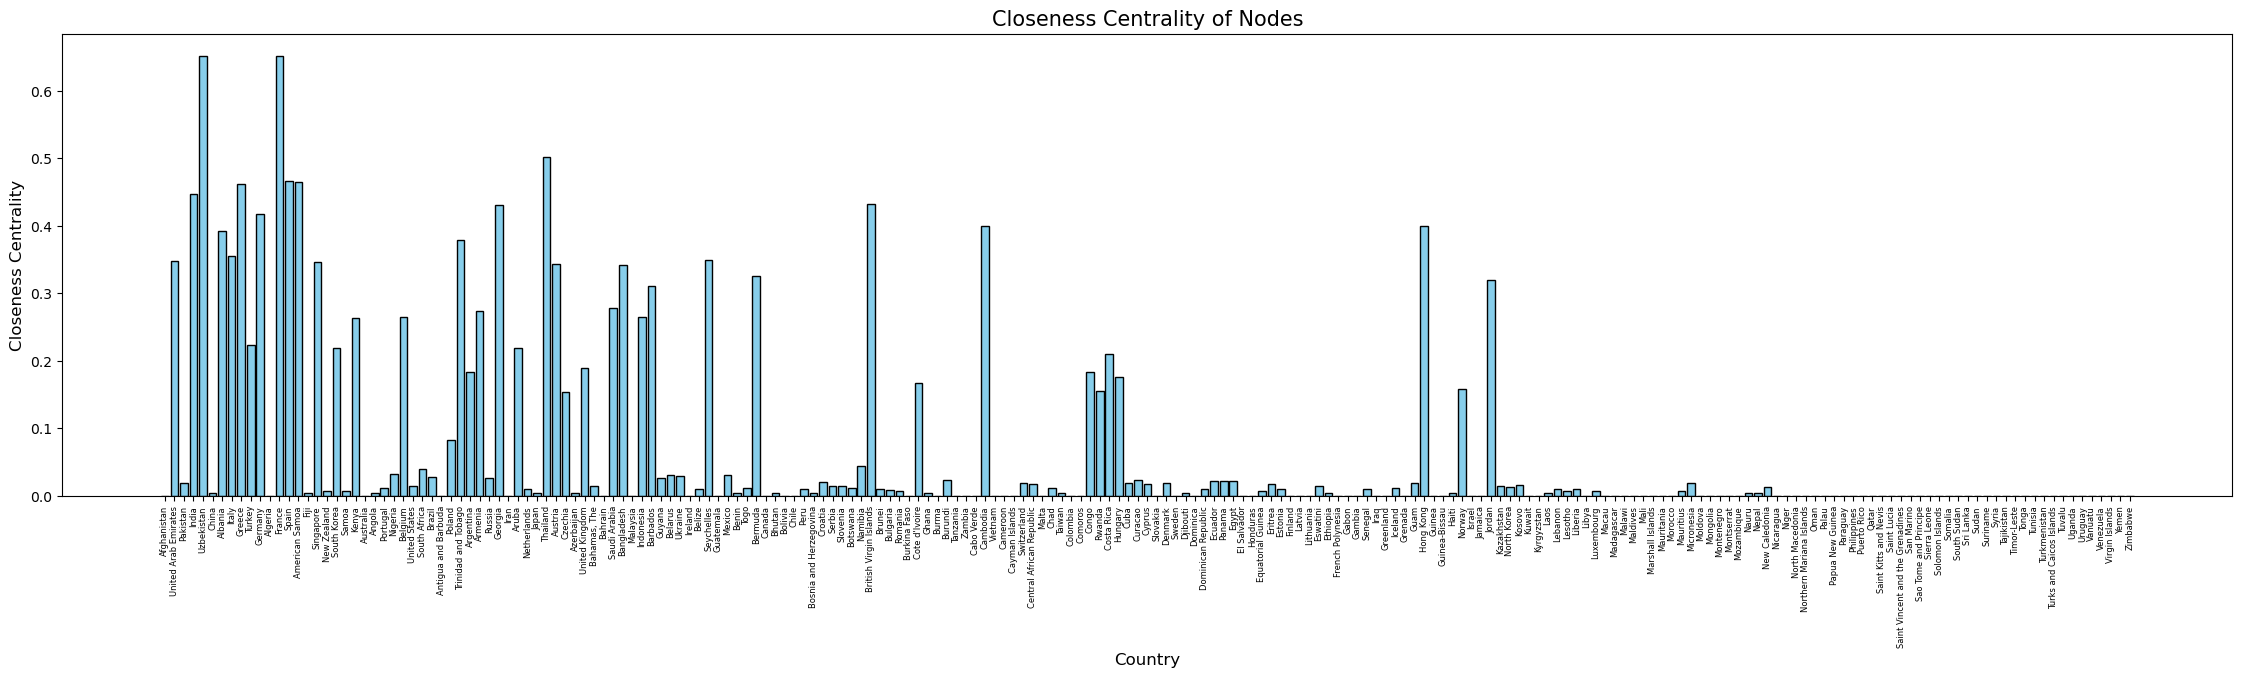

Nodes (Countries) with High Closeness Centrality (> 0.5):
China: 0.6518
United States: 0.6518
Japan: 0.5025

-----Imports Network-----


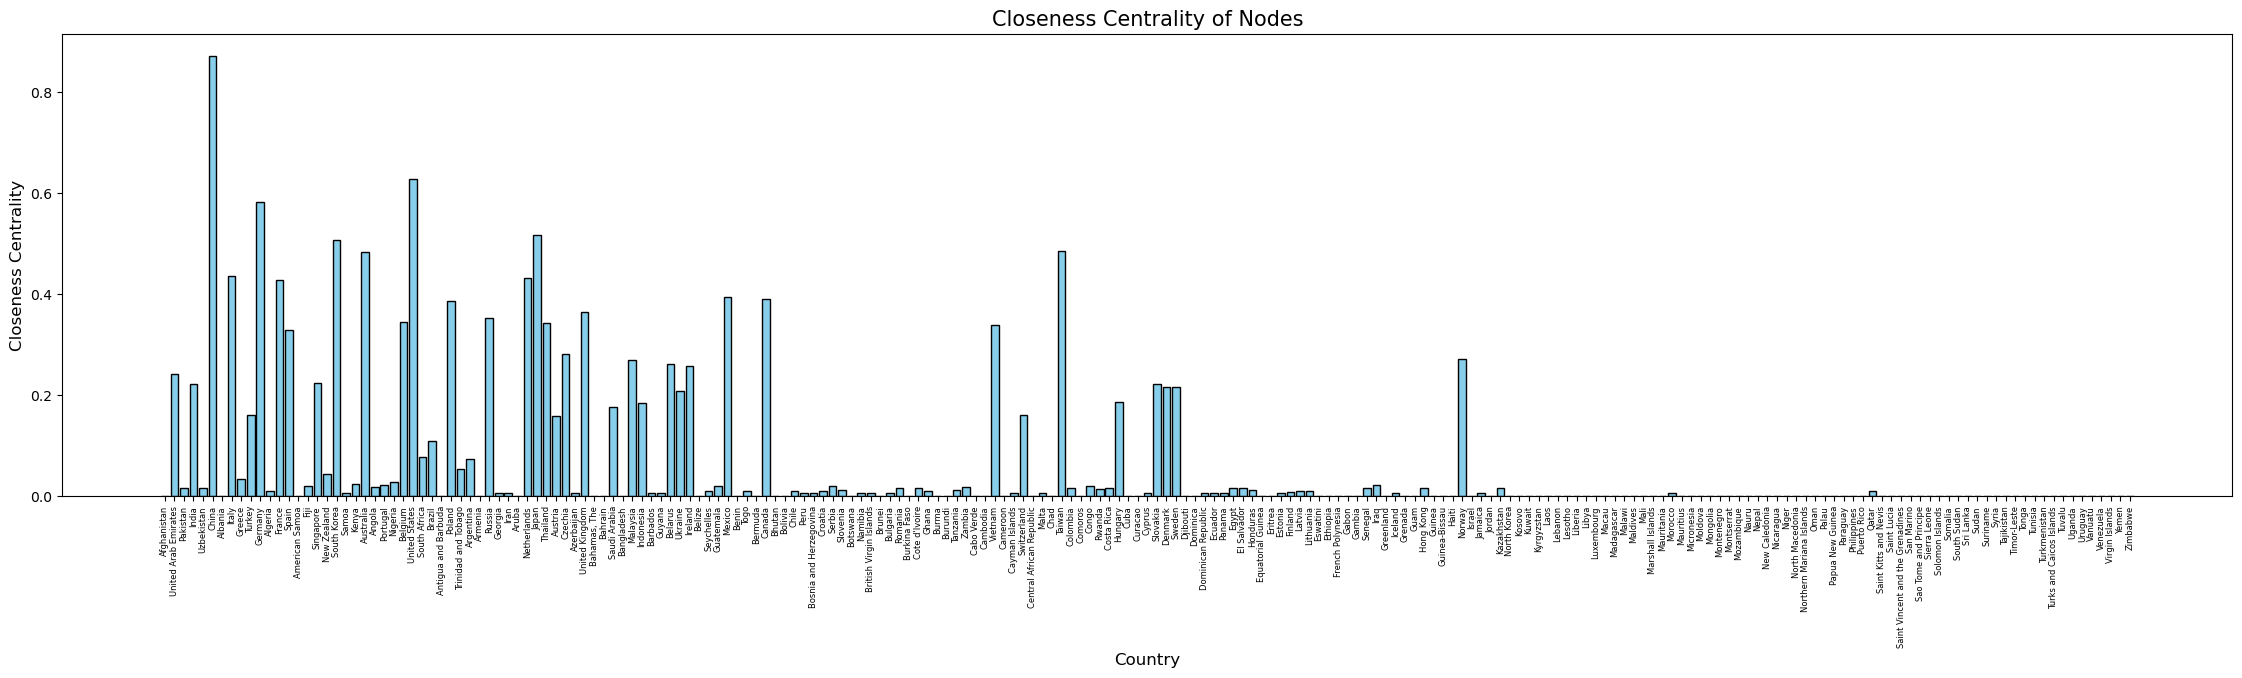

Nodes (Countries) with High Closeness Centrality (> 0.5):
China: 0.8718
Germany: 0.5829
South Korea: 0.5062
United States: 0.6277
Japan: 0.5178


In [57]:
closeness_centrality_export = nx.closeness_centrality(G_export)
closeness_centrality_import = nx.closeness_centrality(G_import)
closeness_centrality_values_export = list(closeness_centrality_export.values())
closeness_centrality_values_import = list(closeness_centrality_import.values())

print("-----Exports Network-----")
high_closeness_nodes_export = centrality(countries, closeness_centrality_export, closeness_centrality_values_export, type='Closeness Centrality',threshold=0.5)
print("\n-----Imports Network-----")
high_closeness_nodes_import = centrality(countries, closeness_centrality_import, closeness_centrality_values_import, type='Closeness Centrality',threshold=0.5)

Closeness centrality distribution

-----Exports Network-----


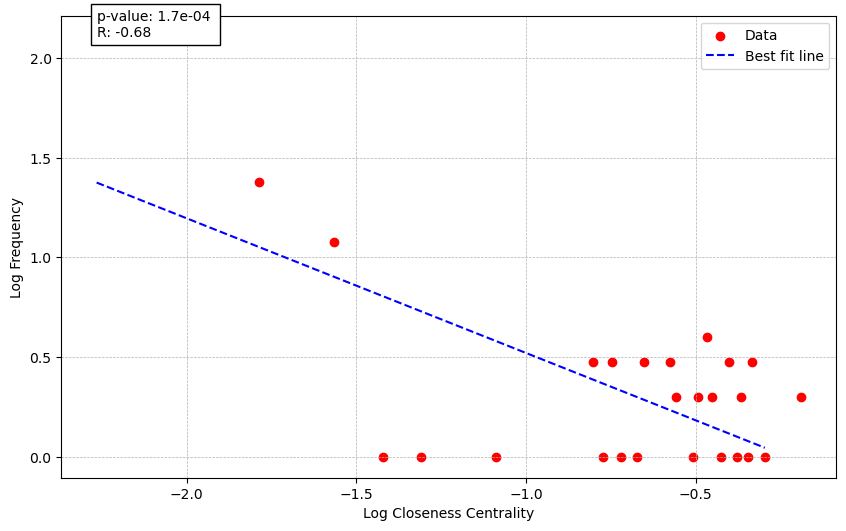

The slope of the line is: -0.6758966469357606

-----Imports Network-----


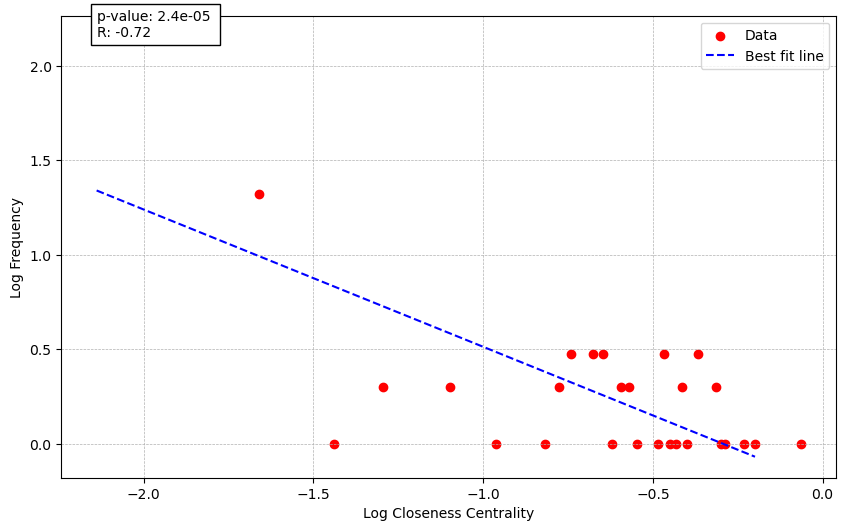

The slope of the line is: -0.7272260243601809


In [61]:
print("-----Exports Network-----")
slope_c_export = plot_centrality_power_law(closeness_centrality_values_export, G_export, bins=60, type='Closeness')
print("\n-----Imports Network-----")
slope_c_import = plot_centrality_power_law(closeness_centrality_values_import, G_import, bins=60, type='Closeness')

Pagerank

-----Exports Network-----


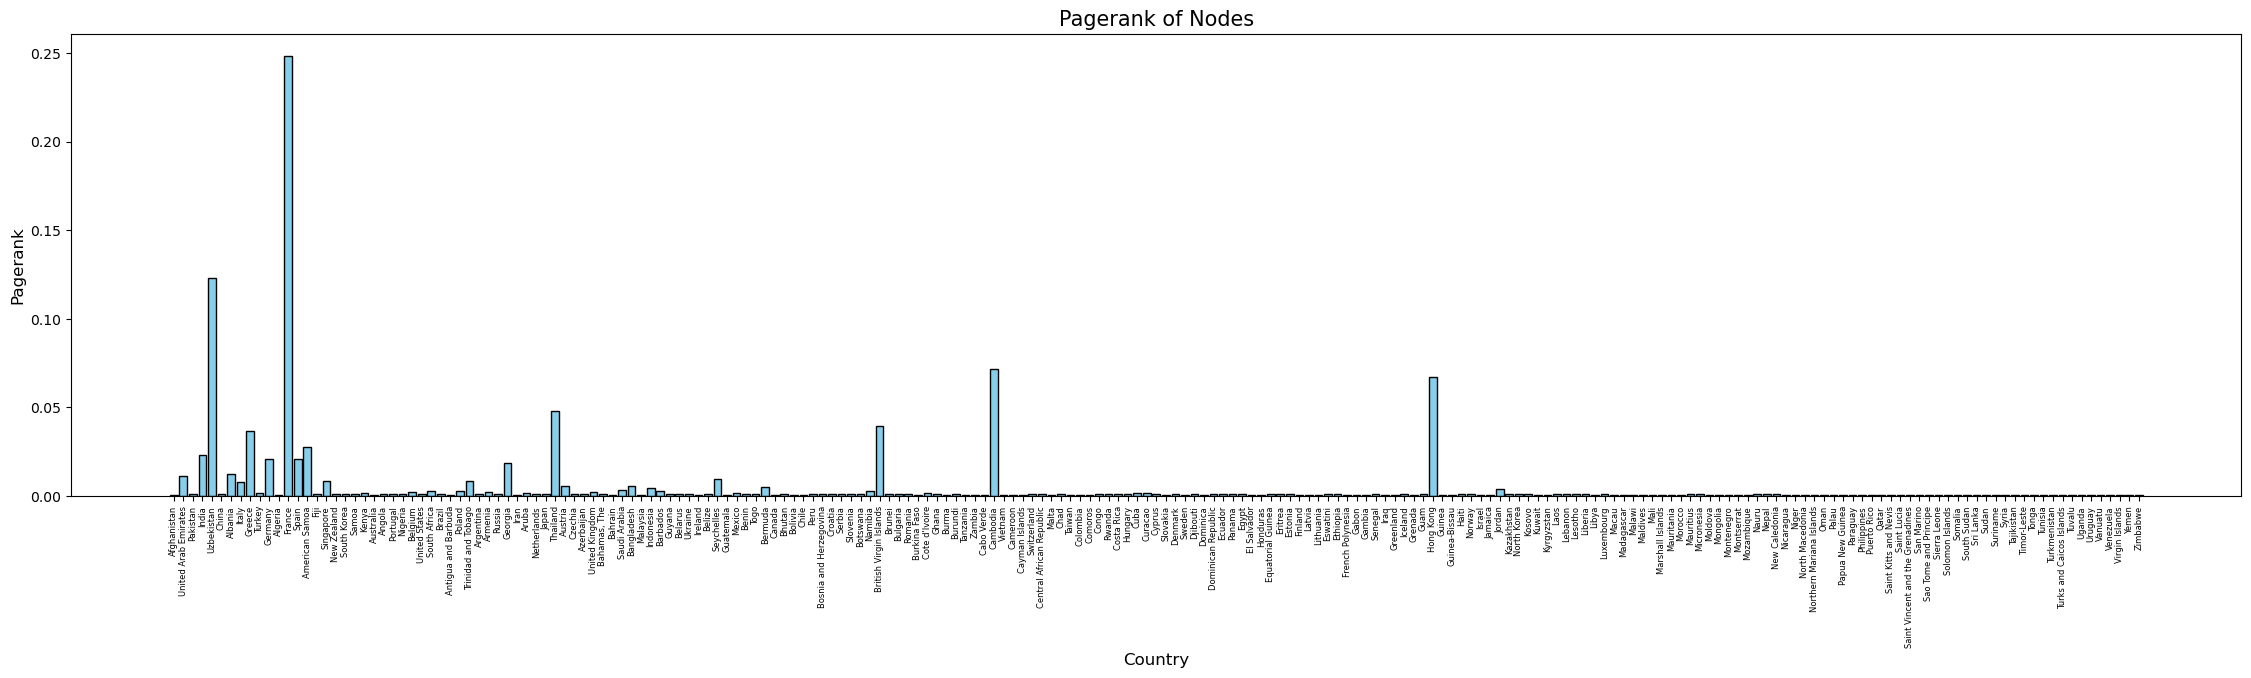

Nodes (Countries) with High Pagerank (> 0.01):
United Arab Emirates: 0.0113
India: 0.0228
China: 0.1229
Italy: 0.0123
Germany: 0.0367
France: 0.0207
United States: 0.2484
United Kingdom: 0.0208
South Korea: 0.0276
Netherlands: 0.0186
Japan: 0.0479
Hong Kong: 0.0394
Canada: 0.0716
Mexico: 0.0669

-----Imports Network-----


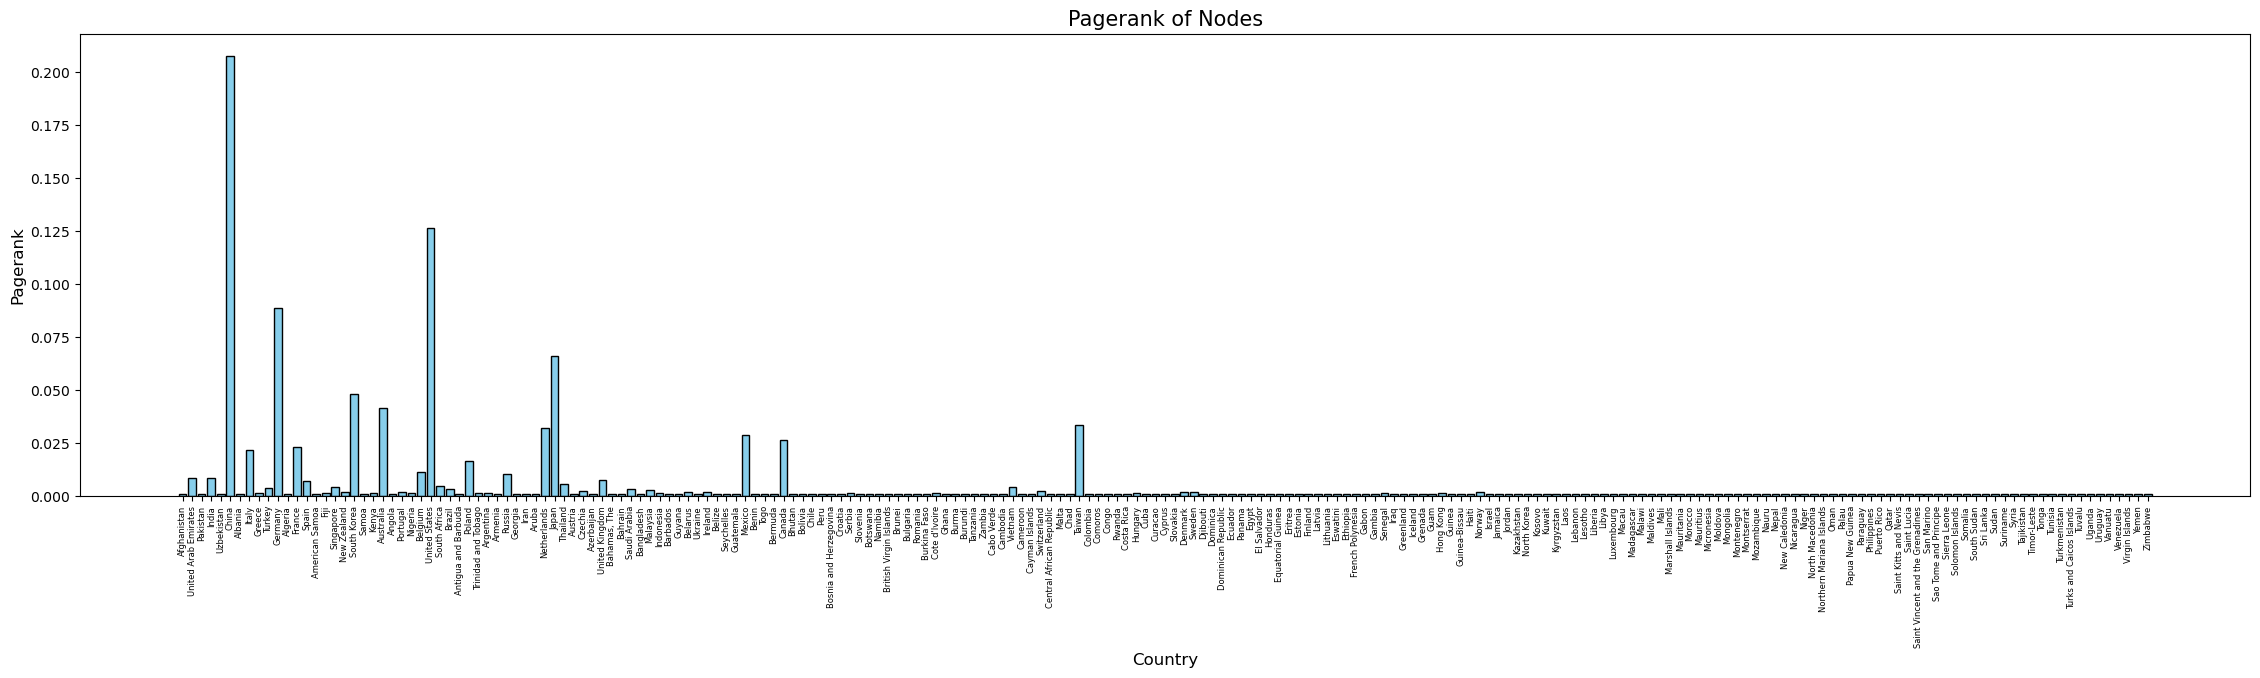

Nodes (Countries) with High Pagerank (> 0.01):
China: 0.2075
Italy: 0.0215
Germany: 0.0887
France: 0.0230
South Korea: 0.0478
Australia: 0.0416
Belgium: 0.0111
United States: 0.1264
Poland: 0.0164
Russia: 0.0103
Netherlands: 0.0321
Japan: 0.0661
Mexico: 0.0285
Canada: 0.0264
Taiwan: 0.0336


In [63]:
G_noloops_export = G_export.copy()
G_noloops_import = G_import.copy()

G_noloops_export.remove_edges_from(nx.selfloop_edges(G_noloops_export))  # Remove self-loops
G_noloops_import.remove_edges_from(nx.selfloop_edges(G_noloops_import))


pagerank_export = nx.pagerank(G_noloops_export)
pagerank_import = nx.pagerank(G_noloops_import)
pagerank_values_export = list(pagerank_export.values())
pagerank_values_import = list(pagerank_import.values())

print("-----Exports Network-----")
high_pagerank_nodes_export = centrality(countries, pagerank_export, pagerank_values_export, type='Pagerank',threshold=0.01)
print("\n-----Imports Network-----")
high_pagerank_nodes_import = centrality(countries, pagerank_import, pagerank_values_import, type='Pagerank',threshold=0.01)

Local Clustering coefficient

The local clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. It is calculated for each node in a graph and quantifies how close its neighbors are to being a complete subgraph (a clique). 

-----Exports Network-----


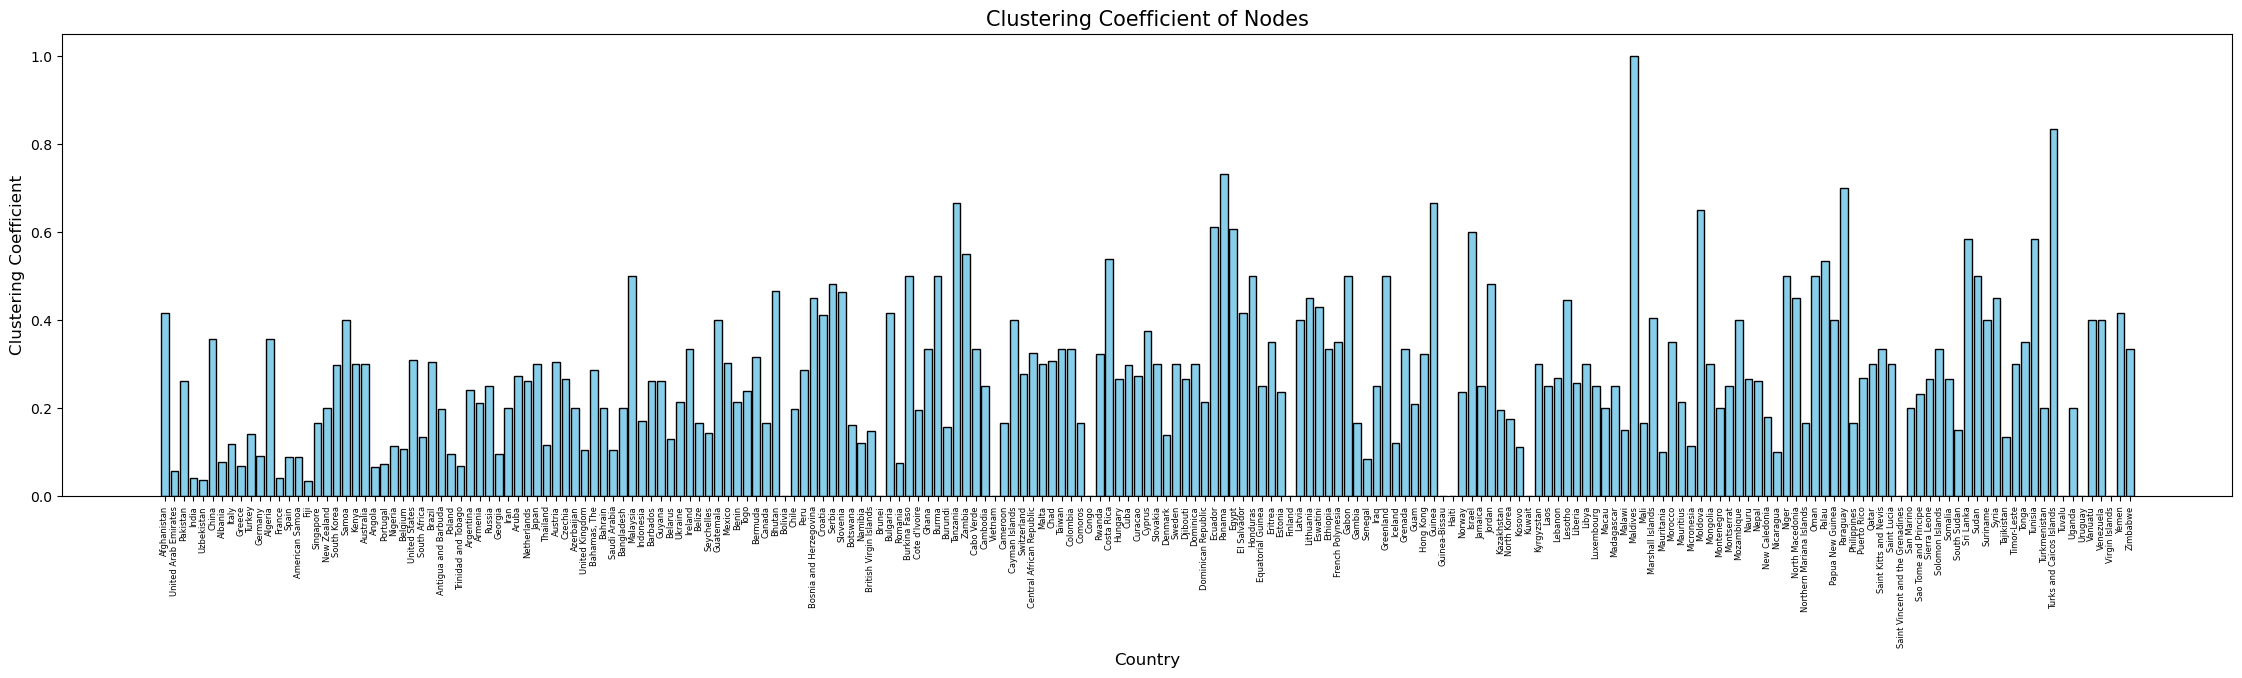

Nodes (Countries) with High Clustering Coefficient (> 0.7):
Honduras: 0.7308
Macau: 1.0000
Tunisia: 0.8333

-----Imports Network-----


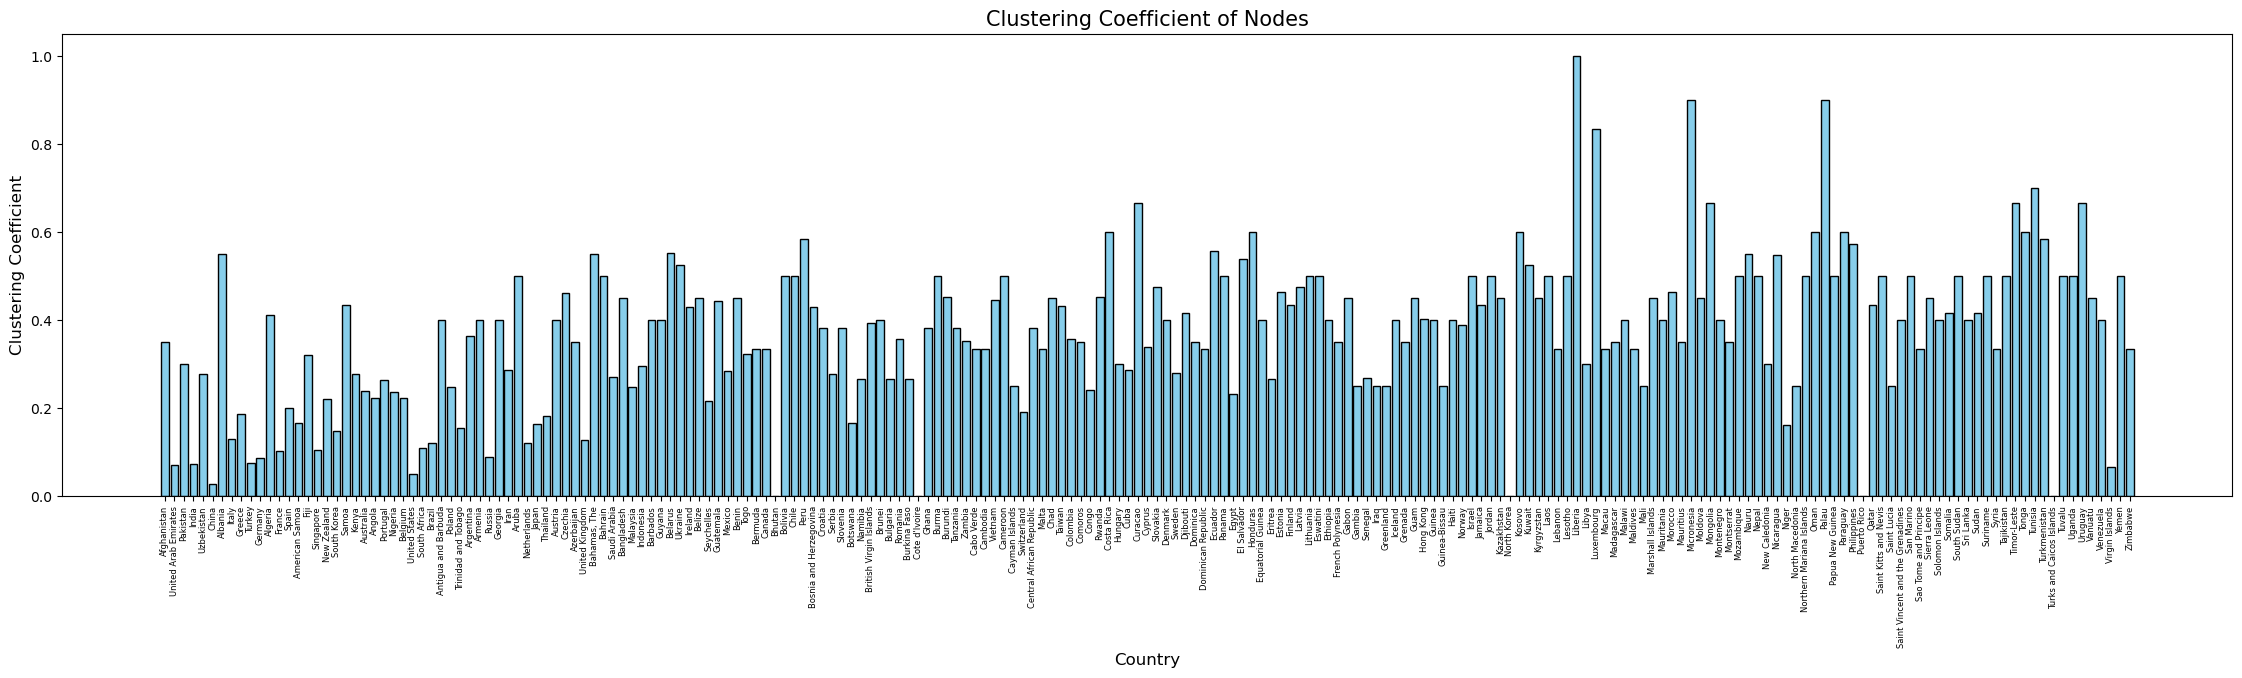

Nodes (Countries) with High Clustering Coefficient (> 0.7):
Liberia: 1.0000
Luxembourg: 0.8333
Micronesia: 0.9000
Palau: 0.9000


In [67]:
clustering_coeffs_export = nx.clustering(G_export)
clustering_coeffs_import = nx.clustering(G_import)
clustering_coeffs_values_export = list(clustering_coeffs_export.values())
clustering_coeffs_values_import = list(clustering_coeffs_import.values())

print("-----Exports Network-----")
high_clustering_nodes_export = centrality(countries, clustering_coeffs_export, clustering_coeffs_values_export, type='Clustering Coefficient',threshold=0.7)
print("\n-----Imports Network-----")
high_clustering_nodes_import = centrality(countries, clustering_coeffs_import, clustering_coeffs_values_import, type='Clustering Coefficient',threshold=0.7)

Correlation between Local Clustering Coefficient and Degree Centrality

Is a measure of how these two properties are related across the nodes of a graph. Degree centrality measures the number of connections a node has, while the local clustering coefficient measures the tendency of a node's neighbors to be connected with each other. By examining their correlation, we can gain insights into the structural properties of the graph.

-----Exports Network-----
Pearson correlation coefficient: -0.3323
P-value: 9.9960e-07


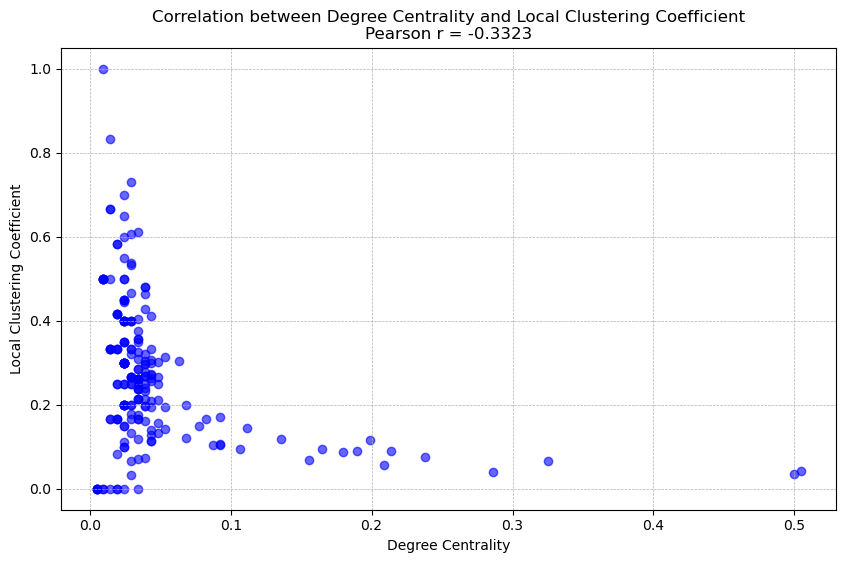


-----Imports Network-----
Pearson correlation coefficient: -0.4171
P-value: 4.0351e-10


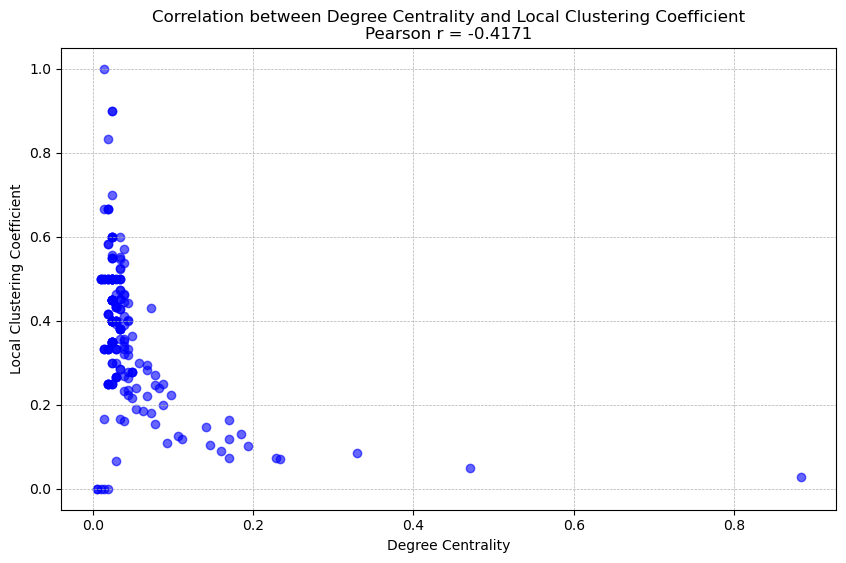

In [72]:
# Pearson correlation coefficient
def correlation_cd(clustering_coeffs_values, degree_centrality_values):
    correlation, p_value = stats.pearsonr(clustering_coeffs_values, degree_centrality_values)
    
    print(f"Pearson correlation coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    
    # Plotting the correlation
    plt.figure(figsize=(10, 6))
    plt.scatter(degree_centrality_values, clustering_coeffs_values, color='b', alpha=0.6)
    plt.xlabel('Degree Centrality')
    plt.ylabel('Local Clustering Coefficient')
    plt.title(f'Correlation between Degree Centrality and Local Clustering Coefficient\nPearson r = {correlation:.4f}')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()
    return correlation, p_value

print("-----Exports Network-----")
correlation_export, p_value_export = correlation_cd(clustering_coeffs_values_export, degree_centrality_values_export)
print("\n-----Imports Network-----")
correlation_import, p_value_import = correlation_cd(clustering_coeffs_values_import, degree_centrality_values_import)

Cliques

Finding cliques in a graph can be useful for understanding the structure and relationships within the graph, such as identifying tightly knit groups of nodes, which might represent communities or highly interconnected subgraphs.

In [76]:
G_undirected_export = G_export.to_undirected()
G_undirected_import = G_import.to_undirected()

cliques_export = list(nx.find_cliques(G_undirected_export))
cliques_import = list(nx.find_cliques(G_undirected_import))

th=6
large_cliques_export = [clique for clique in cliques_export if len(clique) >= th]
large_cliques_import = [clique for clique in cliques_import if len(clique) >= th]

print(f"Clique(s) larger than {th} nodes in the Exports graph:")
for clique in large_cliques_export:
    print(clique)

print(f"Clique(s) larger than {th} nodes in the Imports graph:")
for clique in large_cliques_import:
    print(clique)


largest_clique_export = max(cliques_export, key=len)
largest_clique_import = max(cliques_import, key=len)
print("\nLargest clique in the Exports graph: " + str(largest_clique_export) + " with size: " + str(len(largest_clique_export)))
print("\nLargest clique in the Imports graph: " + str(largest_clique_import) + " with size: " + str(len(largest_clique_import)))

Clique(s) larger than 6 nodes in the Exports graph:
['Slovenia', 'Italy', 'Germany', 'Austria', 'Bosnia and Herzegovina', 'Croatia']
['Belgium', 'United States', 'Netherlands', 'Germany', 'Ireland', 'United Kingdom']
['China', 'Papua New Guinea', 'Australia', 'Taiwan', 'South Korea', 'Japan']
['Spain', 'United States', 'Germany', 'Libya', 'Italy', 'France']
Clique(s) larger than 6 nodes in the Imports graph:
['China', 'Russia', 'Germany', 'Poland', 'Belarus', 'Ukraine']
['China', 'Hungary', 'Italy', 'Germany', 'Poland', 'Netherlands']
['China', 'Hungary', 'Italy', 'Germany', 'Poland', 'Romania']
['China', 'Tunisia', 'France', 'Italy', 'Algeria', 'Germany']
['China', 'Burundi', 'India', 'United Arab Emirates', 'Kenya', 'Saudi Arabia']
['China', 'Algeria', 'Italy', 'Germany', 'France', 'Spain']
['China', 'United States', 'Mexico', 'Guatemala', 'Nicaragua', 'Honduras', 'El Salvador']
['China', 'United States', 'Mexico', 'Guatemala', 'Nicaragua', 'Costa Rica']
['China', 'United States', 'T

K-core and core periphery structures

K-core of a graph is a maximal subgraph in which each vertex has at least degree k. In other words, it's a subgraph where every node is connected to at least k other nodes in that subgraph.

In [82]:
def kcores(G_noloops, a, b):
    k_values = range(a, b)  # Define the k values
    
    for k in k_values:
        k_core_subgraph = nx.k_core(G_noloops, k)
        k_core_nodes = k_core_subgraph.nodes()
        if len(k_core_nodes) > 0:  # Only print non-empty k-cores
            print(f"Nodes in the {k}-core:", k_core_nodes)
    return k_core_nodes
    
print("-----Exports Network-----")
k_core_nodes_export = kcores(G_noloops_export, 4, 10)
print("\n-----Imports Network-----")
k_core_nodes_import = kcores(G_noloops_import, 4, 10)

-----Exports Network-----
Nodes in the 4-core: ['Afghanistan', 'United Arab Emirates', 'Pakistan', 'India', 'China', 'Albania', 'Italy', 'Spain', 'Germany', 'Greece', 'France', 'Algeria', 'United States', 'United Kingdom', 'South Korea', 'American Samoa', 'Australia', 'Ghana', 'Indonesia', 'Burma', 'Portugal', 'Angola', 'Antigua and Barbuda', 'Suriname', 'Barbados', 'Poland', 'Argentina', 'Brazil', 'Chile', 'Armenia', 'Russia', 'Switzerland', 'Bulgaria', 'Iraq', 'Serbia', 'Netherlands', 'Aruba', 'Malaysia', 'Jordan', 'Venezuela', 'Japan', 'Taiwan', 'Austria', 'Azerbaijan', 'Turkey', 'Israel', 'Bahamas, The', 'Singapore', 'Thailand', 'Bahrain', 'Saudi Arabia', 'Bangladesh', 'Jamaica', 'Guyana', 'Trinidad and Tobago', 'Ukraine', 'Belgium', 'Belize', 'Guatemala', 'Benin', 'Nigeria', 'Vietnam', 'Luxembourg', 'Bolivia', 'Peru', 'Colombia', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Botswana', 'South Africa', 'Hong Kong', 'British Virgin Islands', 'Malta', 'Seychelles', 'Brunei', 'Rom

Assortative mixing by degree

Assortative mixing by degree is a measure of the tendency of nodes in a network to connect to other nodes that are similar in terms of their degree. In a network with high assortative mixing by degree, high-degree nodes tend to connect to other high-degree nodes, and low-degree nodes tend to connect to other low-degree nodes. Conversely, in a network with disassortative mixing, high-degree nodes tend to connect to low-degree nodes.

In [86]:
assortativity_coefficient_export = nx.degree_assortativity_coefficient(G_export)
assortativity_coefficient_import = nx.degree_assortativity_coefficient(G_import)

print(f"Assortative Mixing by Degree (Exports Network): {assortativity_coefficient_export:.4f}")
print(f"Assortative Mixing by Degree (Imports Network): {assortativity_coefficient_import:.4f}")

Assortative Mixing by Degree (Exports Network): -0.0221
Assortative Mixing by Degree (Imports Network): -0.1176


Visualize the degree correlations

-----Exports Network-----


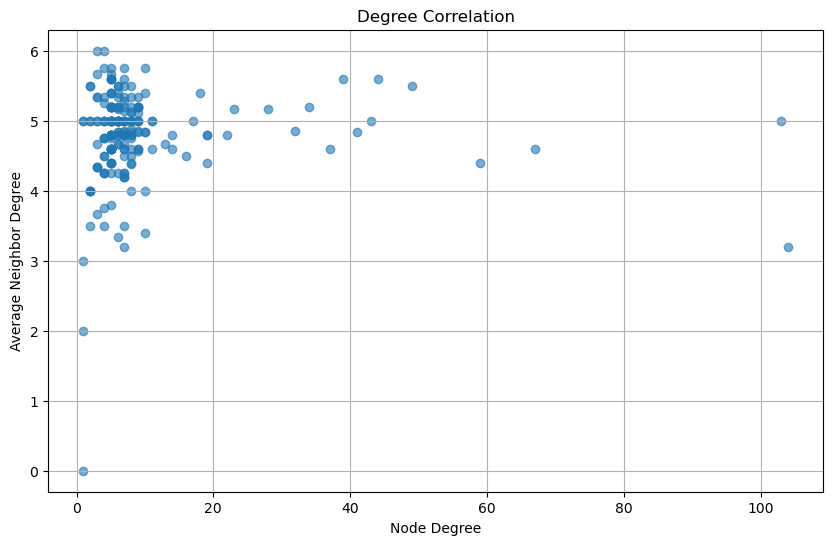


-----Imports Network-----


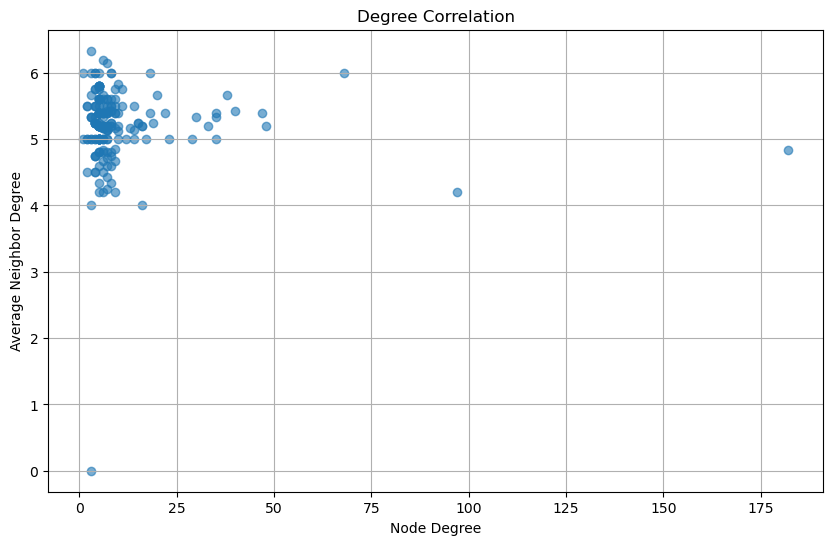

In [91]:
def deg_cor(G):
    # Compute the degree of each node
    degree = dict(G.degree())
    
    # Compute the average neighbor degree for each node
    avg_neighbor_degree = nx.average_neighbor_degree(G)
    
    # Prepare data for plotting
    degrees = list(degree.values())
    avg_neighbor_degrees = [avg_neighbor_degree[node] for node in G.nodes()]
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(degrees, avg_neighbor_degrees, alpha=0.6)
    plt.xlabel('Node Degree')
    plt.ylabel('Average Neighbor Degree')
    plt.title('Degree Correlation')
    plt.grid(True)
    plt.show()

print("-----Exports Network-----")
deg_cor(G_export)
print("\n-----Imports Network-----")
deg_cor(G_import)

Density

Graph density is a measure of how many edges are present in the graph compared to the maximum possible number of edges. It provides a sense of how "dense" or "sparse" the graph is.

In [89]:
graph_density_export = nx.density(G_export)
graph_density_import = nx.density(G_import)

print(f"Graph Density (Exports): {graph_density_export:.4f}")
print(f"Graph Density (Imports): {graph_density_import:.4f}")

Graph Density (Exports): 0.0228
Graph Density (Imports): 0.0235


Gephi 

In [ ]:
# Export graph to gephi format
nx.write_gexf(G_export, "export.gexf")
nx.write_gexf(G_import, "import.gexf")

In [ ]:
# Export CSV with measures
with open('measures.csv', 'w', newline='') as csvfile:
    fieldnames = ['Node', 'Degree', 'Eigenvector', 'Betweenness', 'Closeness', 'PageRank', 'ClusteringCoefficient']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node in G.nodes():
        writer.writerow({
            'Node': node,
            'Degree': degree_centrality[node],
            'Eigenvector': eigenvector_centrality[node],
            'Betweenness': betweenness_centrality[node],
            'Closeness': closeness_centrality[node],
            'PageRank': pagerank[node],  # Access PageRank value for the node
            'ClusteringCoefficient': clustering_coeffs[node],
        })